# CosmoDC

### Goals
- How to interface QP and sacc
- How to create n(z) uncertainties from an ensemble of n(z)'s

### Requirements
- **A sacc file**: we will use the sacc file of Prat et al 2022 (2212.09345). This sacc file contains the summary statistics measured from the CosmoDC2 simulations using the DESC TXPipe pipeline. The summary statistics include the angular power spectra of the shear-shear, position-shear, and position-position correlations, as well as the cross-correlations between the different probes. The sacc file also contains the redshift distributions of the galaxies in the simulations. For more details see Prat et al 2022. The data can found in NERSC at '/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/gaussian/data_vectors'.

- **A series of QP ensenbles**: For this tutorials I have created a series of QP ensembles using the cosmoDC2_v1.1.4_image_with_photoz_v1 simulations. This catalog contains photometric redshifts that were computed with the `BPZ` template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract) by Sam Schmidt. We use all the available pixels and impose a 24.1 magnitude cut in the i-band following Prat et al. The edges of the tomographic bins are also taken from Prat et al.

### Special Dependencies
- **sacc**: standard DESC library to load and save data.
- **nz_prior**: this very own library, used to compute n(z) uncertainties from n(z) ensembles.
- **PACC** is a plotting library (https://github.com/jaimerzpP/pacc) for sacc files.

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
import qp
import sacc
import yaml
import scipy
import nz_prior as nzp

In [2]:
method = "bpz"
source_0 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/shear_0.npz")
source_1 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/shear_1.npz")
source_2 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/shear_2.npz")
source_3 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/shear_3.npz")
source_4 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/shear_4.npz")
lens_0 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/lens_0.npz")
lens_1 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/lens_1.npz")
lens_2 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/lens_2.npz")
lens_3 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/lens_3.npz")
lens_4 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/lens_4.npz")


### Load Data

In [3]:
def nz_interpolate(source, n):
    # Extract the zgrid and photo_hists from source_0
    znodes = source['znodes']
    photo_hists = source['photo_hists']
    dz = znodes[1] - znodes[0]

    # Create an interpolation function
    print(znodes.shape, photo_hists.shape)
    interp_func = interp1d(znodes, photo_hists, kind='cubic', axis=0)

    # Define the new zgrid with 1000 nodes
    new_znodes = np.linspace(znodes.min(), znodes.max(), n)
    new_dz = new_znodes[1] - new_znodes[0]
    new_zgrid = np.append([new_znodes[0] - new_dz/2], new_znodes + new_dz/2)

    # Interpolate the photo_hists to the new zgrid
    new_photo_hists = interp_func(new_znodes)
    new_source = {'znodes': new_znodes, 
                  'zgrid': new_zgrid,
                  'photo_hists': new_photo_hists}
    return new_source

In [4]:
# Sacc file
s = sacc.Sacc.load_fits("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y = yaml.load(open("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc_gcwl_wlwl.yml"), Loader=yaml.FullLoader)

# Interpolated nz
#source_0 = nz_interpolate(source_0, 1000)
#source_1 = nz_interpolate(source_1, 1000)
#source_2 = nz_interpolate(source_2, 1000)
#source_3 = nz_interpolate(source_3, 1000)
#source_4 = nz_interpolate(source_4, 1000)

#lens_0 = nz_interpolate(lens_0, 1000)
#lens_1 = nz_interpolate(lens_1, 1000)
#lens_2 = nz_interpolate(lens_2, 1000)
#lens_3 = nz_interpolate(lens_3, 1000)
#lens_4 = nz_interpolate(lens_4, 1000)

tomos = {'source_0': source_0,
        'source_1': source_1,
        'source_2': source_2,
        'source_3': source_3,
        'source_4': source_4,
        'lens_0': lens_0,
        'lens_1': lens_1,
        'lens_2': lens_2,
        'lens_3': lens_3,
        'lens_4': lens_4}

crosscorrs_method = "BinWise"

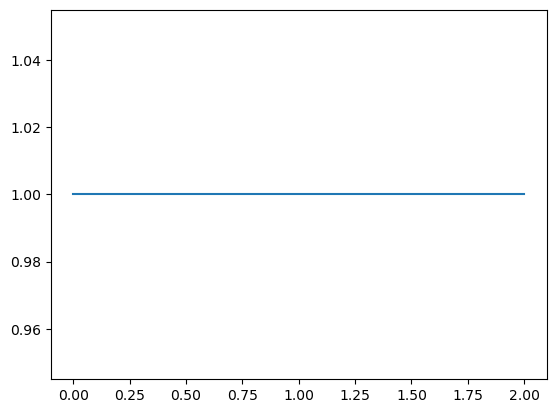

In [5]:
#cle = pacc.ClsEnsemble(s, y, label="CosmoDC2")
#pacc.plot_cls([cle], cle.pairs)

line3 =plt.plot([1, 1, 1], '-', color='C0')

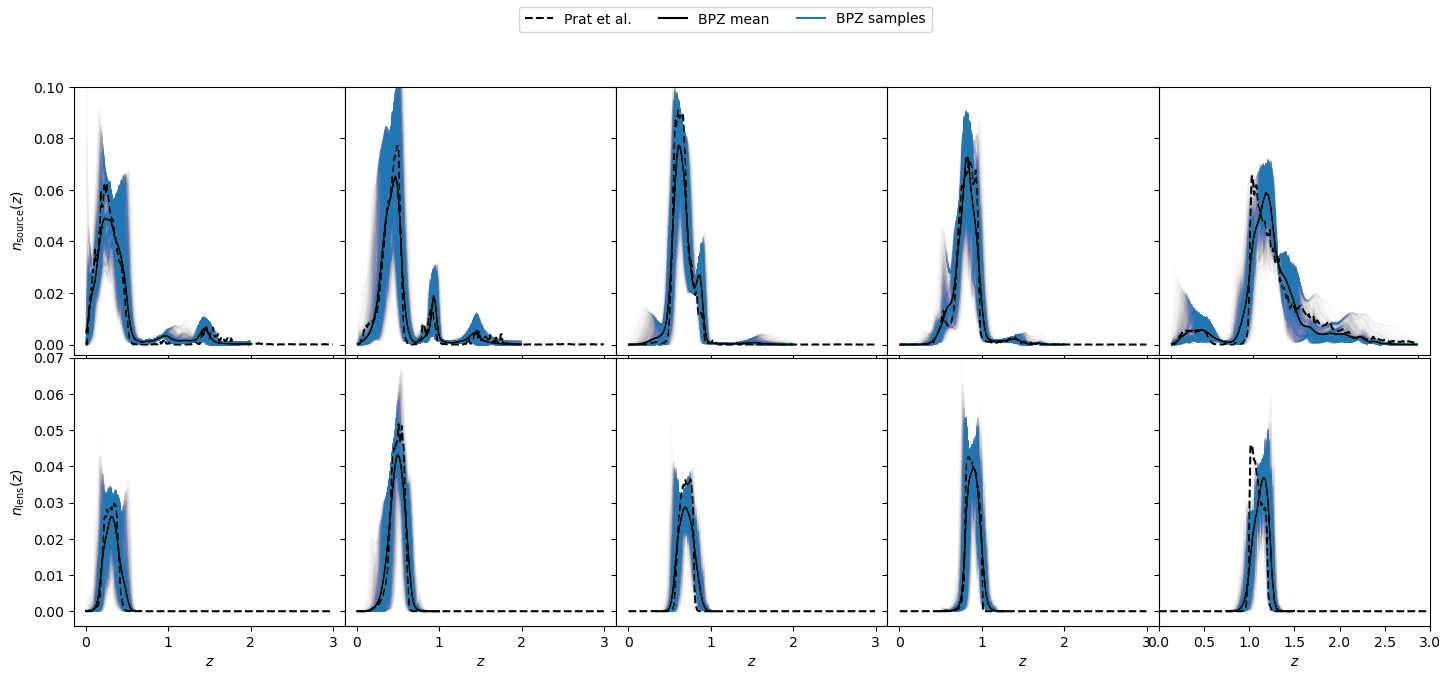

In [6]:
figure, axis = plt.subplots(2, 5, figsize=(5*3.5, 7))
figure.subplots_adjust(wspace=0, hspace=0.01)

#colors = ['limegreen', 'forestgreen', 'darkgreen', 'olive', 'orange']
lens_keys = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))
    line1, = axis[0, i].plot(spec.z, alpha*spec.nz, 'k--')
    line2, = axis[0, i].plot(tomo['znodes'], np.mean(tomo['photo_hists'], axis=1)/norm, 'k-')
    axis[0, i].plot(tomo['znodes'], tomo['photo_hists'][:100]/norm, '-', color='C0', alpha=0.005)
    #axis[0].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    #axis[0, i].set_title(source_labels[i], y=0.8)
    axis[0, i].set_ylim([-0.004, 0.1])
    axis[0, i].set_xlabel(r'$z$')
    if i == 0:
        axis[0, i].set_ylabel(r'$n_{\rm source}(z)$')

#colors = ['skyblue', 'teal', 'blue', 'purple', 'darkviolet']
lens_keys = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))
    axis[1, i].plot(spec.z, alpha*spec.nz, 'k--')
    axis[1, i].plot(tomo['znodes'], np.mean(tomo['photo_hists'], axis=1)/norm, 'k-')
    axis[1, i].plot(tomo['znodes'], tomo['photo_hists'][:100]/norm, '-', color='C0', alpha=0.005)
    #axis[1].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    #axis[1, i].set_title(lens_labels[i], y=0.8)
    axis[1, i].set_ylim([-0.004, 0.07])
    axis[1, i].set_xlabel(r'$z$')
    if i == 0:
        axis[1, i].set_ylabel(r'$n_{\rm lens}(z)$')
    else:
        axis[0, i].set_yticklabels([])
        axis[1, i].set_yticklabels([])

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")
lines = [line1, line2, line3[0]]
labels = ["Prat et al.", "BPZ mean", "BPZ samples"]
figure.legend(lines, labels, loc='upper center', ncols=3)

plt.xlim([0.0, 3.0])
plt.show()
#figure.savefig(f"/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/nzs_{method}.pdf")

In [7]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        tomo = tracers_dict[key]
        nzs = tomo['photo_hists']
        zs = tomo['znodes']
        norms = np.sum(nzs, axis=0)
        axis[0,i].plot(zs, nzs/norms, 'k-', alpha=0.005)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_ylim([-0.001, 0.1])
        axis[0,i].set_title(key)
        if i == 0:
            axis[0,i].set_ylabel(r'$n_{\rm lens}(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

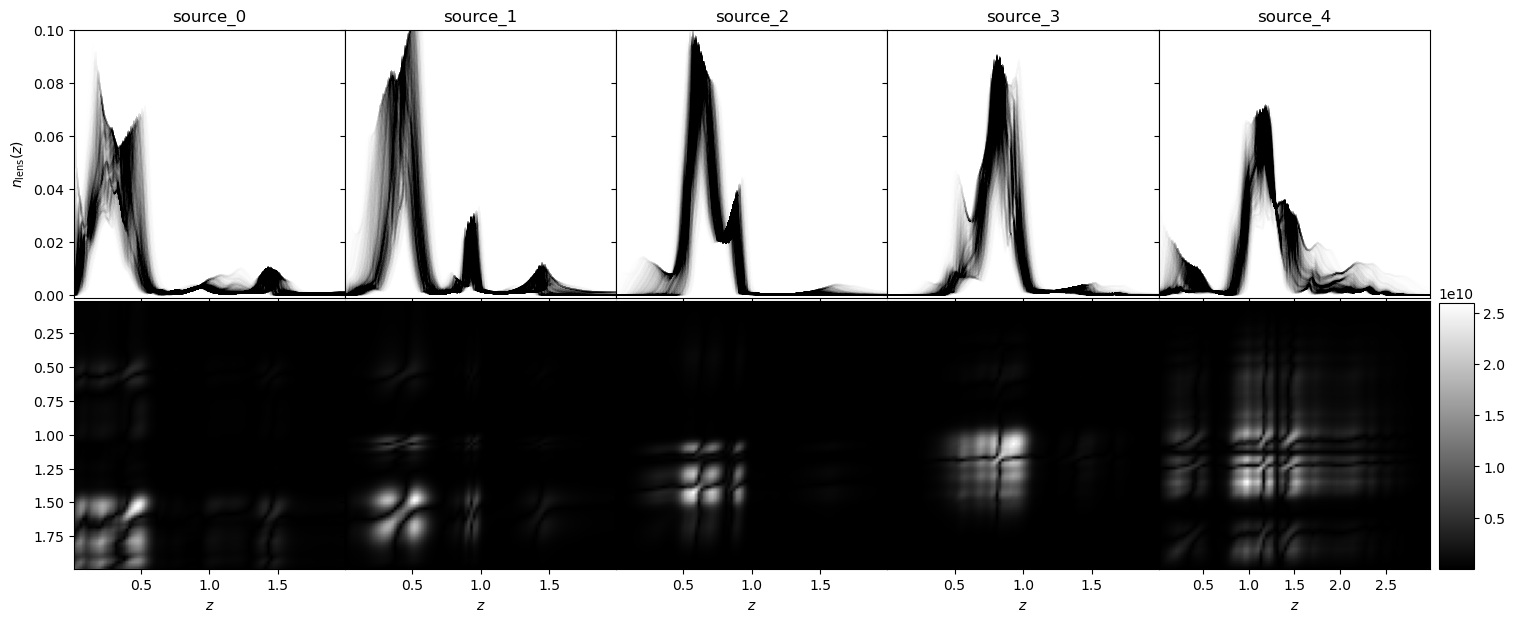

In [8]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(tomos, plot_tracers)

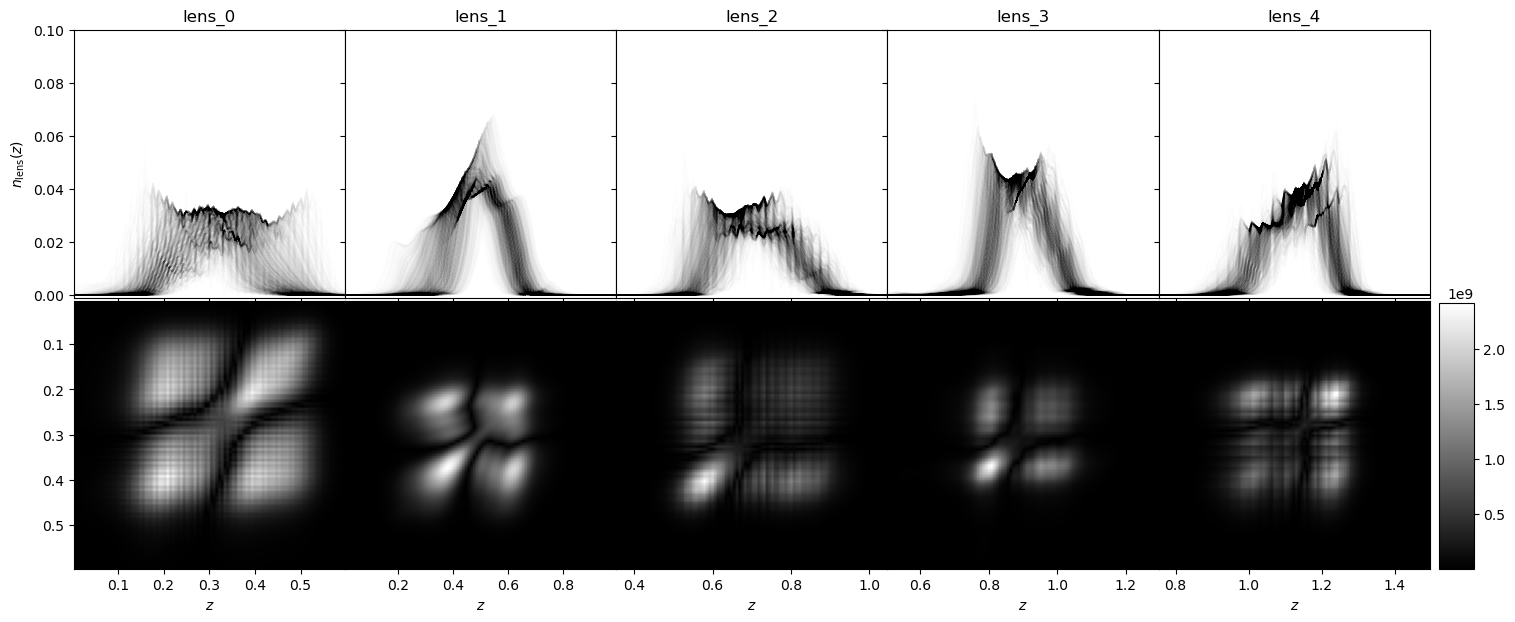

In [9]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(tomos, plot_tracers)

# Interfacing SACC and QP

In [10]:
def make_qp(ens):
    pzs = ens['photo_hists'].T
    zs_edges = ens['zgrid']
    return qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":pzs})

def update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        ens = enss[key]
        q = make_qp(ens)
        ss.add_tracer('Qpnz', key, q)
    return ss

ss_qp = update_sacc_qp(s, tomos)

# Computing Uncertainties

Now we are just going to apply the methods of nz_prior described in the basic tutorial for each of the tracers in the sacc file. For the sake of brevity we will only use the qp tracers but the same can be done for the NZTracers.

In [11]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        zs, nzs = tracers_dict[key]
        nzs = nzs.T
        axis[0,i].plot(zs, nzs, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        #axis[0,i].errorbar(zs, nz_mean, yerr=np.sqrt(np.diag(cov)), fmt='k-')
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_title(key)
        axis[0,i].set_ylim([-0.001, 0.1])
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

## Shifts

In [12]:
shifts_priors = nzp.PriorSacc(ss_qp, 
                            model="Shifts",
                            compute_crosscorrs="Full")

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


Removed no burn in
Removed no burn in


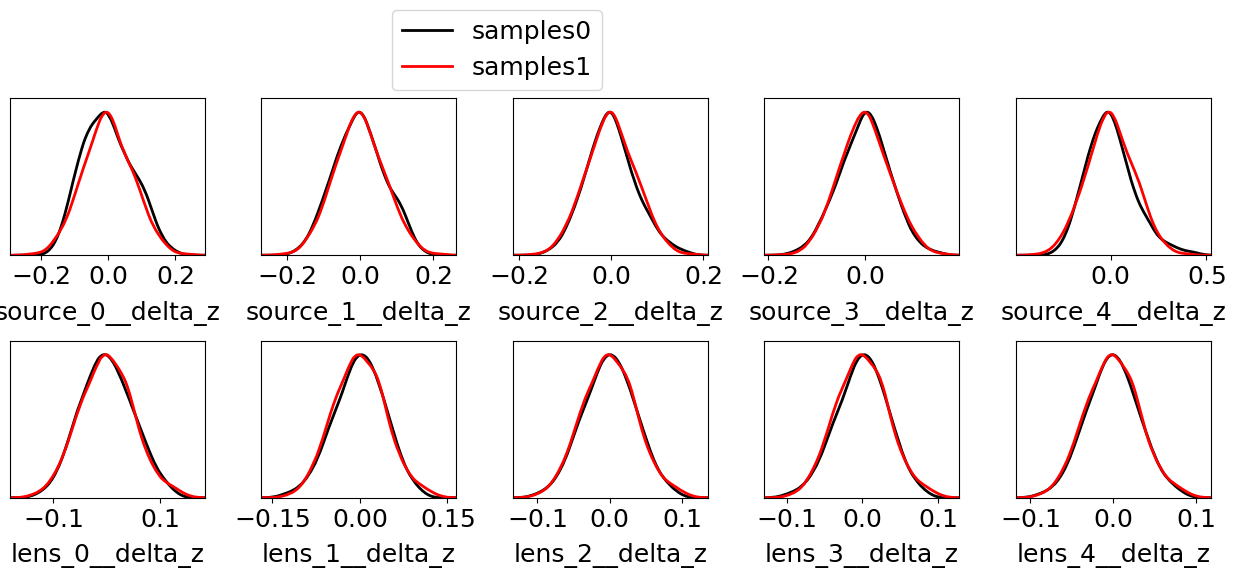

In [13]:
shifts_priors.plot_prior(mode="1D", add_prior=True, nx=5, lws=2)

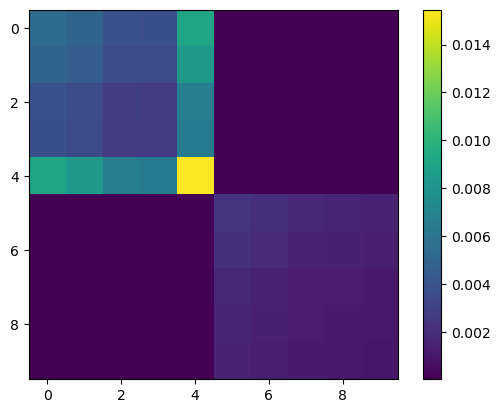

In [14]:
mean, cov, chol = shifts_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(cov)
plt.colorbar()

In [15]:
mean, cov, chol = shifts_priors.get_prior()
file_name = "dz_prior.npz"
save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_dz_{}_priors/".format(method) + file_name
np.savez(save_to, mean=mean, cov=cov, chol=chol)

In [16]:
shifted_nzs = {}
for i in range(500):
    prior_sample = shifts_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_model(nz_fid, params[0])[1]
        if i == 0:
            shifted_nzs[tracer_name] = [nz_fid[0], shifted_nz]
        else:

            shifted_nzs[tracer_name] = [nz_fid[0], np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]


In [17]:
_shifted_nzs = {}
for i in range(2000):
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = model_obj.params[0][i]
        shifted_nz = nzp.shift_model(nz_fid, params)[1]
        if i == 0:
            _shifted_nzs[tracer_name] = [nz_fid[0], shifted_nz]
        else:

            _shifted_nzs[tracer_name] = [nz_fid[0], np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]

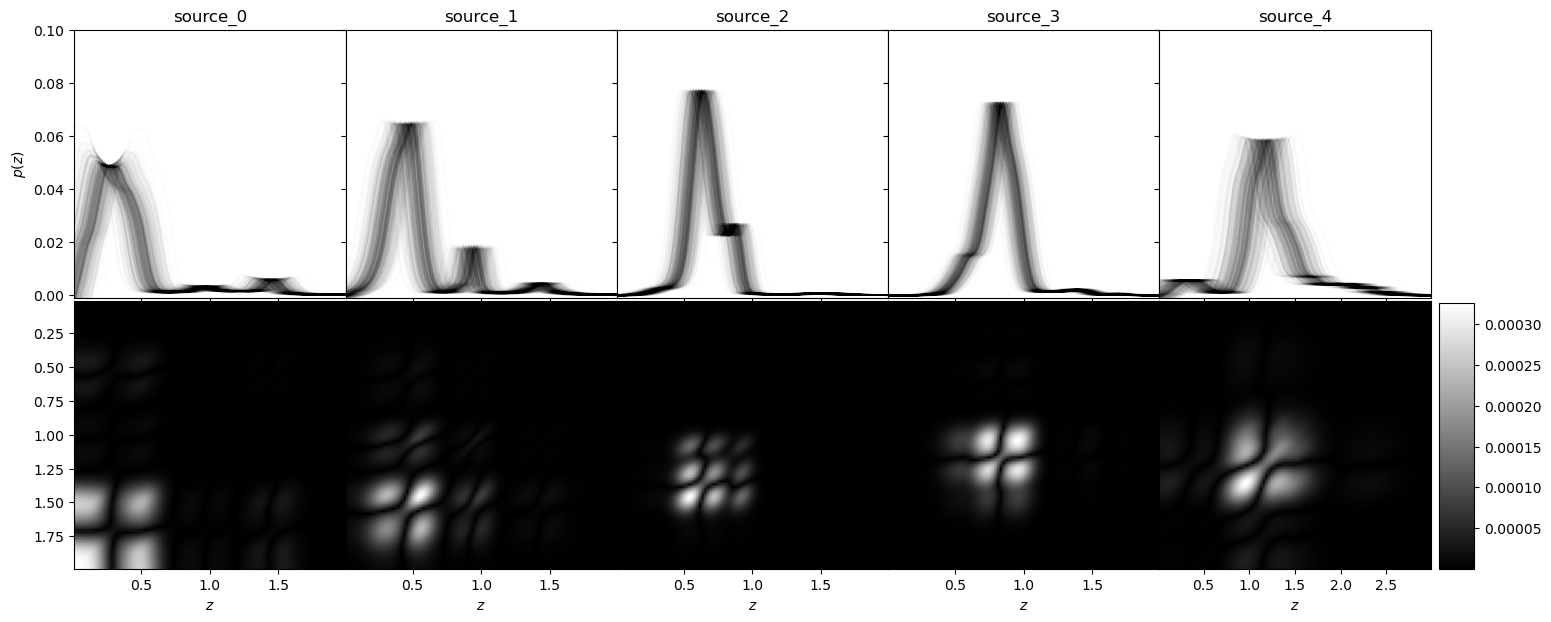

In [18]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(shifted_nzs, plot_tracers)

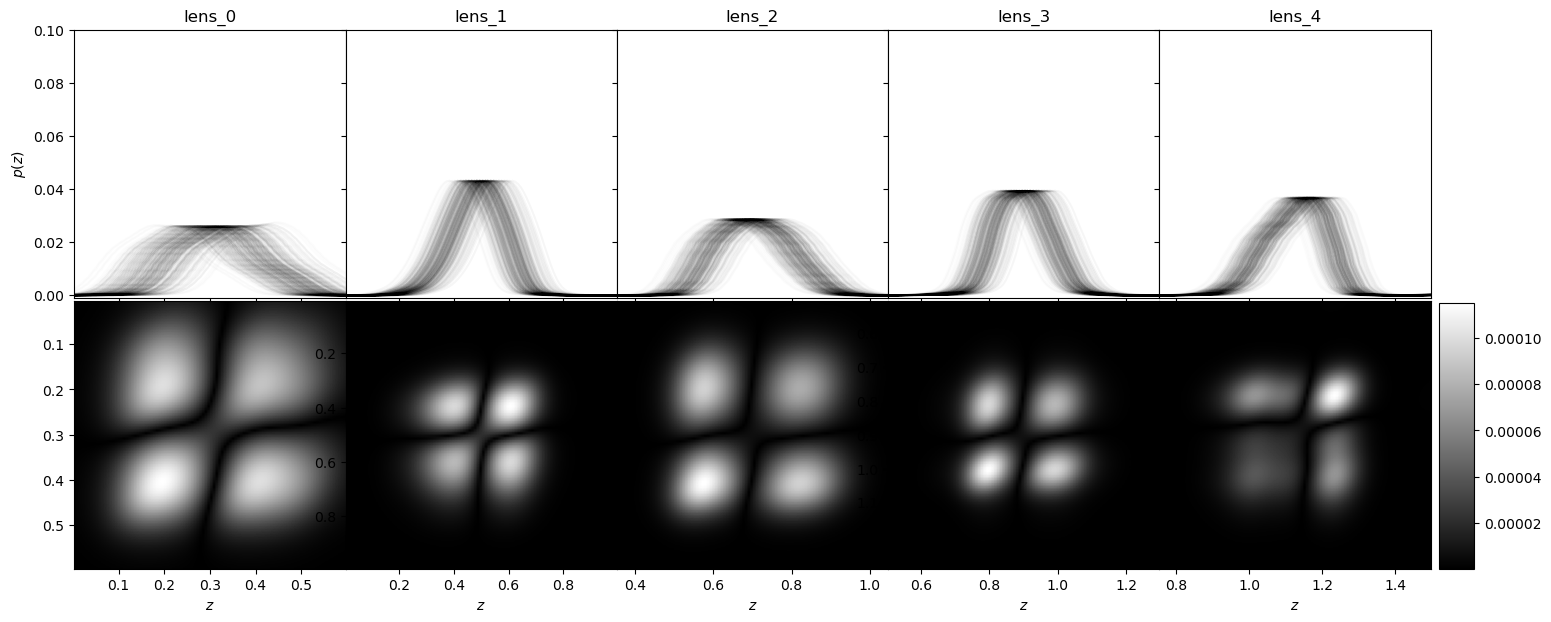

In [19]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(shifted_nzs, plot_tracers)

In [20]:
shifts_var_comp = {}
_shifts_var_comp = {}
shifts_skew_comp = {}
_shifts_skew_comp = {}
shifts_kurt_comp = {}
_shifts_kurt_comp = {}
for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        shifted_nzs_i = shifted_nzs[tracer_name][1].T
        _shifted_nzs_i = _shifted_nzs[tracer_name][1].T
        nzs = model_obj.nzs
        zs = model_obj.z
        cov = np.cov(shifted_nzs_i)
        _cov = np.cov(_shifted_nzs_i)
        __cov = model_obj.nz_cov
        errs = np.sqrt(np.diag(cov))
        _errs = np.sqrt(np.diag(_cov))
        __errs = np.sqrt(np.diag(__cov))
        sk = scipy.stats.skew(shifted_nzs_i, axis=1)
        _sk = scipy.stats.skew(_shifted_nzs_i, axis=1)
        __sk = scipy.stats.skew(nzs, axis=0)
        ku = scipy.stats.kurtosis(shifted_nzs_i, axis=1)
        _ku = scipy.stats.kurtosis(_shifted_nzs_i, axis=1)
        __ku = scipy.stats.kurtosis(nzs)
        print(tracer_name, np.mean(errs), np.mean(_errs), np.mean(__errs))
        print(tracer_name, np.mean(sk), np.mean(_sk), np.mean(__sk))
        print(tracer_name, np.mean(ku), np.mean(_ku), np.mean(__ku))
        print("=====")
        shifts_var_comp[tracer_name]   = [zs, (errs-__errs)/__errs]
        _shifts_var_comp[tracer_name]  = [zs, (_errs-__errs)/__errs]
        shifts_skew_comp[tracer_name]  = [zs, (sk-__sk)/__sk]
        _shifts_skew_comp[tracer_name] = [zs, (_sk-__sk)/__sk]
        shifts_kurt_comp[tracer_name]  = [zs, (ku-__ku)/__ku]
        _shifts_kurt_comp[tracer_name] = [zs, (_ku-__ku)/__ku]


source_0 0.004041594027962023 0.004042698318534114 0.004203544467801479
source_0 2.1562850336132406 2.156593245842395 1.089871935162711
source_0 21.350634537906757 21.371214838001336 2.976247856472152
=====
source_1 0.005326319412626295 0.0053274293744983384 0.005915508482667201
source_1 1.833720441159073 1.832674978296186 1.951176083612043
source_1 12.462917613858068 12.471240072499322 11.418885104639767
=====
source_2 0.004165624618112359 0.004166192233298706 0.0038540940899966436
source_2 1.692463972273974 1.692044255417934 3.1801783128477465
source_2 15.129407124194163 15.143711268907747 52.538439103022085
=====
source_3 0.0035667486470733595 0.003567653246151783 0.003826968983939829
source_3 1.8767034029220946 1.8765118205850564 4.181483337161585
source_3 14.22652659247575 14.236103746013239 67.10002905978006
=====
source_4 0.00482073264288339 0.004821265475373248 0.00394747346337585
source_4 1.1161199880792587 1.1141503309130887 3.283442142074541
source_4 6.800385308279797 6.7933

In [21]:
#shifts_Ds = {}
#for tracer_name in shifted_nzs.keys():
#    model_obj = shifts_priors.model_objs[tracer_name]
#    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
#    nzs = shifted_nzs[tracer_name][1]
#    mu_2 = np.mean(nzs, axis=0)
#    K_2 = np.cov(nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    shifts_Ds[tracer_name] = np.abs(D)

## Shifts & widths

In [22]:
SnWs_priors = nzp.PriorSacc(ss_qp, 
                            model="ShiftsWidths",
                            compute_crosscorrs="Full")

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


Removed no burn in
Removed no burn in


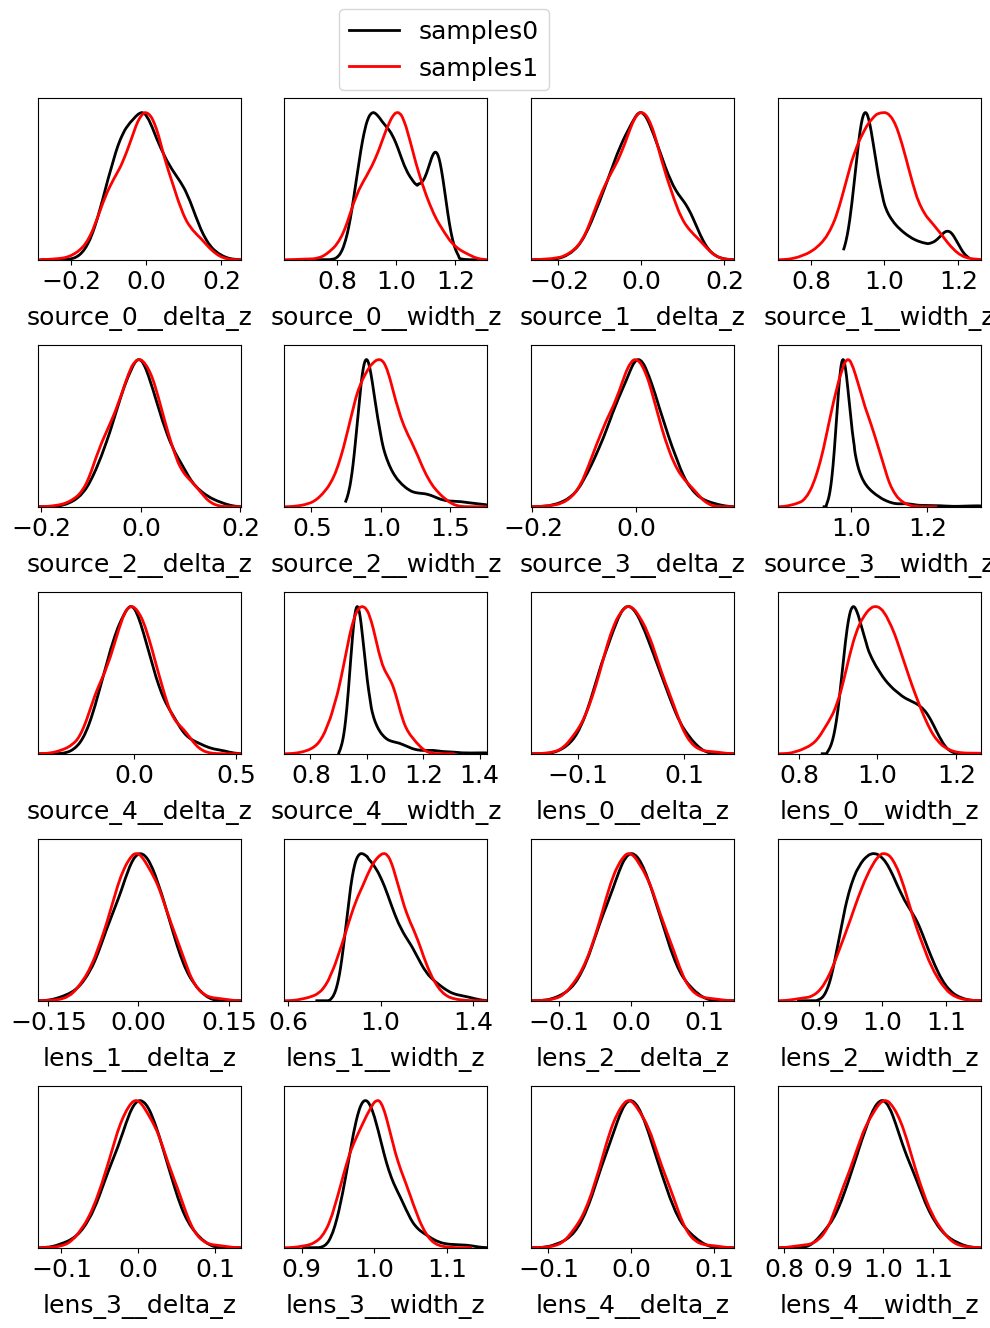

In [23]:
SnWs_priors.plot_prior(mode="1D", add_prior=True, nx=4, lws=2)

In [24]:
mean, cov, chol = SnWs_priors.get_prior()
file_name = "wzdz_prior.npz"
save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_wzdz_{}_priors/".format(method) + file_name
np.savez(save_to, mean=mean, cov=cov, chol=chol)


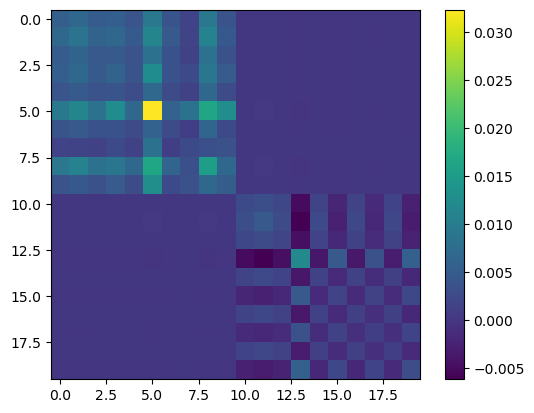

In [25]:
mean, cov, chol = SnWs_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(cov)
plt.colorbar()

In [26]:
SnWs_nzs = {}
for i in range(500):
    prior_sample = SnWs_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_and_width_model(nz_fid, params)[1]
        if i == 0:
            SnWs_nzs[tracer_name] = [nz_fid[0], shifted_nz]
        else:

            SnWs_nzs[tracer_name] = [nz_fid[0], np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]

In [27]:
_SnWs_nzs = {}
for i in range(2000):
    prior_sample = SnWs_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = model_obj.params.T[i]
        shifted_nz = nzp.shift_and_width_model(nz_fid, params)[1]
        if i == 0:
            _SnWs_nzs[tracer_name] = [nz_fid[0], shifted_nz]
        else:

            _SnWs_nzs[tracer_name] = [nz_fid[0], np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]


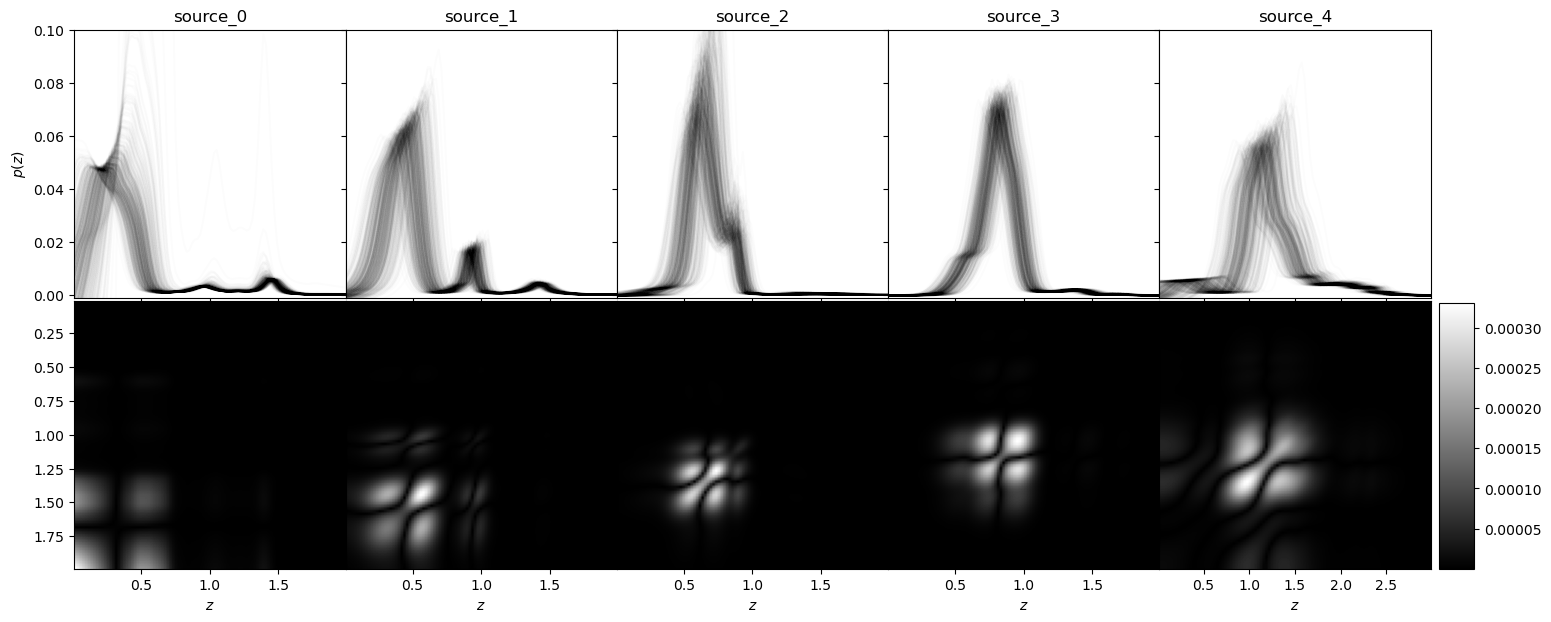

In [28]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

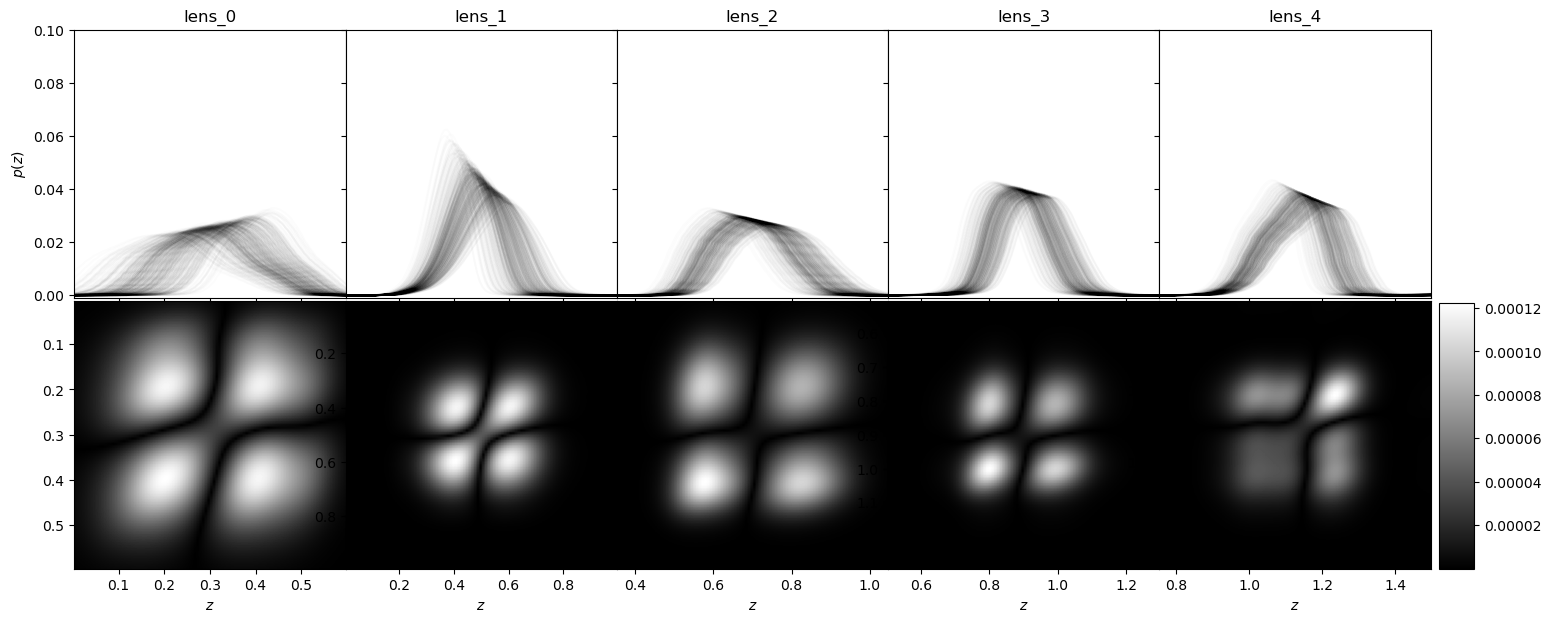

In [29]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

In [30]:
SnWs_var_comp = {}
_SnWs_var_comp = {}
SnWs_skew_comp = {}
_SnWs_skew_comp = {}
SnWs_kurt_comp = {}
_SnWs_kurt_comp = {}
for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        shifted_nzs_i = SnWs_nzs[tracer_name][1].T
        _shifted_nzs_i = _SnWs_nzs[tracer_name][1].T
        nzs = model_obj.nzs
        zs = model_obj.z
        cov = np.cov(shifted_nzs_i)
        _cov = np.cov(_shifted_nzs_i)
        __cov = model_obj.nz_cov
        errs = np.sqrt(np.diag(cov))
        _errs = np.sqrt(np.diag(_cov))
        __errs = np.sqrt(np.diag(__cov))
        sk = scipy.stats.skew(shifted_nzs_i, axis=1)
        _sk = scipy.stats.skew(_shifted_nzs_i, axis=1)
        __sk = scipy.stats.skew(nzs, axis=0)
        ku = scipy.stats.kurtosis(shifted_nzs_i, axis=1)
        _ku = scipy.stats.kurtosis(_shifted_nzs_i, axis=1)
        __ku = scipy.stats.kurtosis(nzs)
        print(tracer_name, np.mean(errs), np.mean(_errs), np.mean(__errs))
        print(tracer_name, np.mean(sk), np.mean(_sk), np.mean(__sk))
        print(tracer_name, np.mean(ku), np.mean(_ku), np.mean(__ku))
        print("=====")
        SnWs_var_comp[tracer_name]   = [zs, (errs-__errs)/__errs]
        _SnWs_var_comp[tracer_name]  = [zs, (_errs-__errs)/__errs]
        SnWs_skew_comp[tracer_name]  = [zs, (sk-__sk)/__sk]
        _SnWs_skew_comp[tracer_name] = [zs, (_sk-__sk)/__sk]
        SnWs_kurt_comp[tracer_name]  = [zs, (ku-__ku)/__ku]
        _SnWs_kurt_comp[tracer_name] = [zs, (_ku-__ku)/__ku]

source_0 0.012210050155704328 0.012200568906693379 0.004203544467801479
source_0 10.595609734861709 10.604551186817998 1.089871935162711
source_0 294.6430978705145 295.12829785964556 2.976247856472152
=====
source_1 0.005589093501897867 0.0055901564260536244 0.005915508482667201
source_1 1.4161369612526025 1.4161791794062273 1.951176083612043
source_1 9.044766536447169 9.05277781530962 11.418885104639767
=====
source_2 0.005178110278747746 0.0051774545045732544 0.0038540940899966436
source_2 1.6335082598988537 1.6344163322948566 3.1801783128477465
source_2 8.144542709143842 8.156237747701471 52.538439103022085
=====
source_3 0.003716009683698243 0.00371690033099294 0.003826968983939829
source_3 1.6739224979394567 1.6740139239478626 4.181483337161585
source_3 9.765945997230073 9.772038064522626 67.10002905978006
=====
source_4 0.005354611473880251 0.005354647175371858 0.00394747346337585
source_4 1.1859522094904924 1.1835711427729694 3.283442142074541
source_4 6.807038548052264 6.797788

In [31]:
#SnWs_Ds = {}
#for tracer_name in SnWs_nzs.keys():
#    model_obj = SnWs_priors.model_objs[tracer_name]
#    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
#    nzs = SnWs_nzs[tracer_name][1]
#    mu_2 = np.mean(nzs, axis=0)
#    K_2 = np.cov(nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    SnWs_Ds[tracer_name] = np.abs(D)

## GP

In [32]:
gp_priors_3 = nzp.PriorSacc(
    ss_qp,
    model="GP",
    compute_crosscorrs=crosscorrs_method,
    n=3,
    )
gp_priors = nzp.PriorSacc(
    ss_qp,
    model="GP",
    compute_crosscorrs=crosscorrs_method,
    n=5,
    )
gp_priors_10 = nzp.PriorSacc(
    ss_qp,
    model="GP",
    compute_crosscorrs=crosscorrs_method,
    n=10,
    )
gp_priors_20 = nzp.PriorSacc(
    ss_qp,
    model="GP",
    compute_crosscorrs=crosscorrs_method,
    n=20,
    )

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4
Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4
Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4
Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making mod

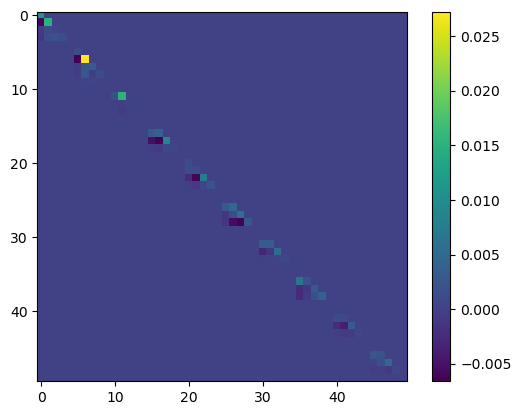

In [33]:
mean, cov, chol = gp_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(chol)
plt.colorbar()

Removed no burn in
Removed no burn in


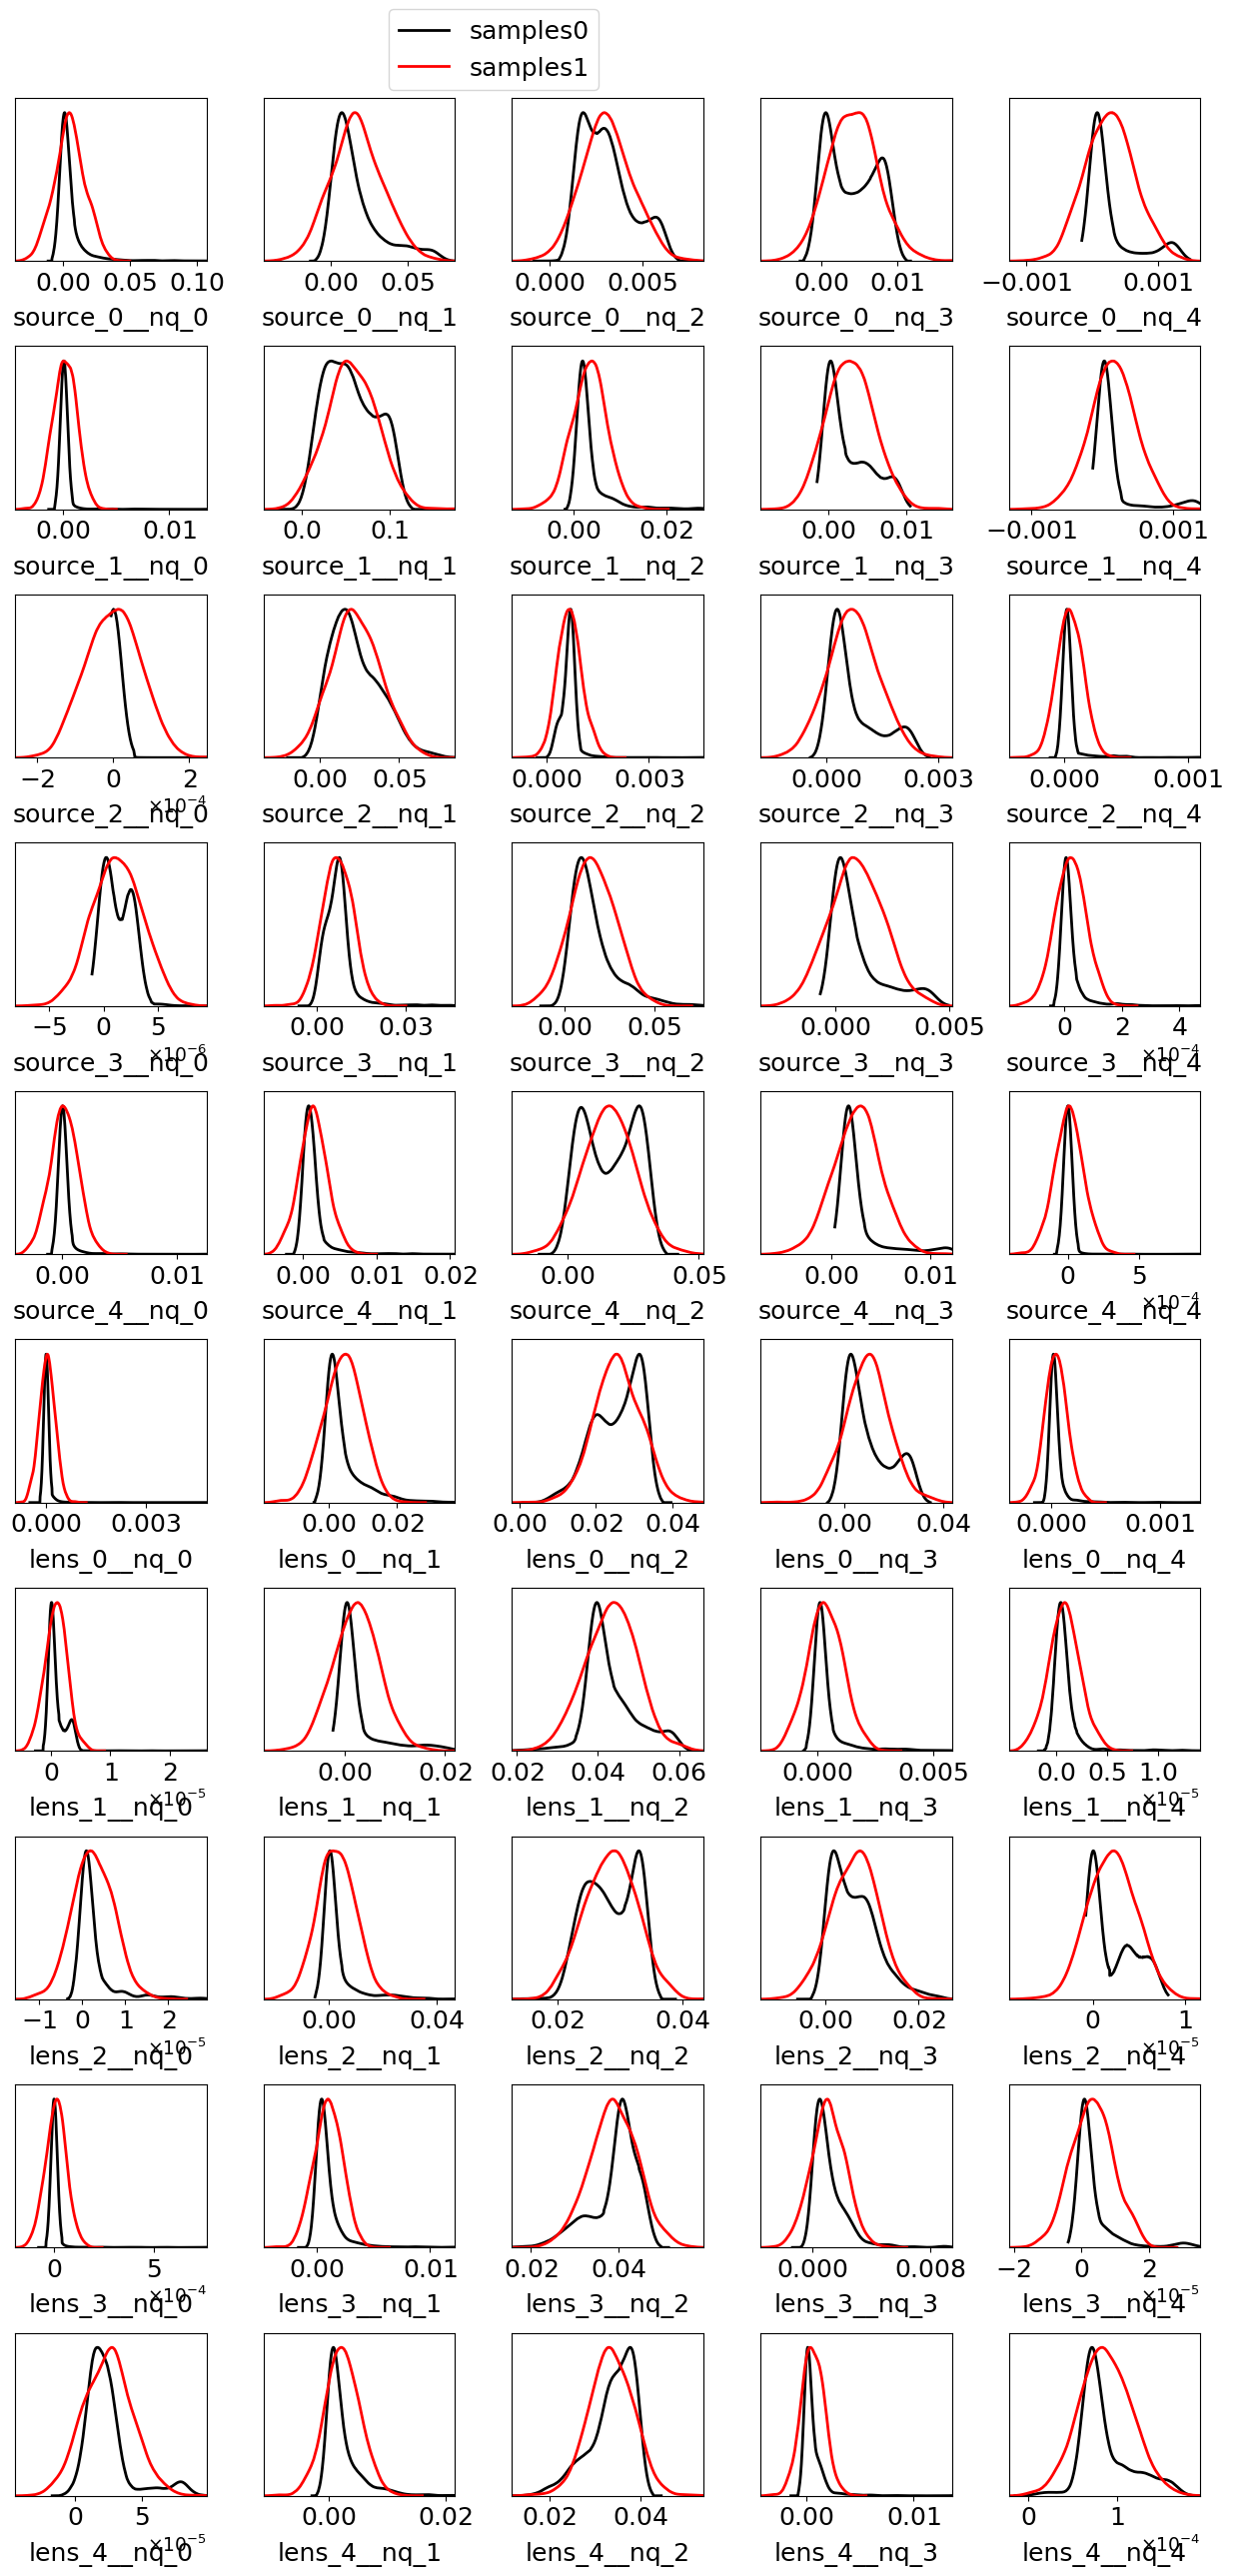

In [34]:
gp_priors.plot_prior(mode="1D", add_prior=True, nx=5, lws=2)

In [35]:
gp_nzs_3 = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = gp_priors_3.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    z = model_obj.z
    _, _, chol = model_obj.get_prior()
    W = model_obj.W
    W = W @ chol
    _nzs = np.array([nzp.linear_model(nz_mean, W) for i in range(500)])
    gp_nzs_3[tracer_name] = [z, _nzs]

In [36]:
gp_nzs = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = gp_priors.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    z = model_obj.z
    _, _, chol = model_obj.get_prior()
    W = model_obj.W
    W = W @ chol
    _nzs = np.array([nzp.linear_model(nz_mean, W) for i in range(500)])
    gp_nzs[tracer_name] = [z, _nzs]

In [37]:
gp_nzs_10 = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = gp_priors_10.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    z = model_obj.z
    _, _, chol = model_obj.get_prior()
    W = model_obj.W
    W = W @ chol
    _nzs = np.array([nzp.linear_model(nz_mean, W) for i in range(500)])
    gp_nzs_10[tracer_name] = [z, _nzs]

In [38]:
gp_nzs_20 = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = gp_priors_20.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    z = model_obj.z
    _, _, chol = model_obj.get_prior()
    W = model_obj.W
    W = W @ chol
    _nzs = np.array([nzp.linear_model(nz_mean, W) for i in range(500)])
    gp_nzs_20[tracer_name] = [z, _nzs]

In [39]:
_gp_nzs = {}
for i in range(500):
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = gp_priors.model_objs[tracer_name]
        nz_mean = model_obj.nz_mean
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = model_obj.params.T[i]
        nq = params - model_obj.nq_mean #model_obj.nqs[i]-model_obj.nq_mean
        W = model_obj.W
        nz = nz_mean + np.dot(W, nq)
        z = model_obj.z
        if i == 0:
            _gp_nzs[tracer_name] = [z, nz]
        else:
            _gp_nzs[tracer_name] = [z, np.vstack([gp_nzs[tracer_name][1], nz])]

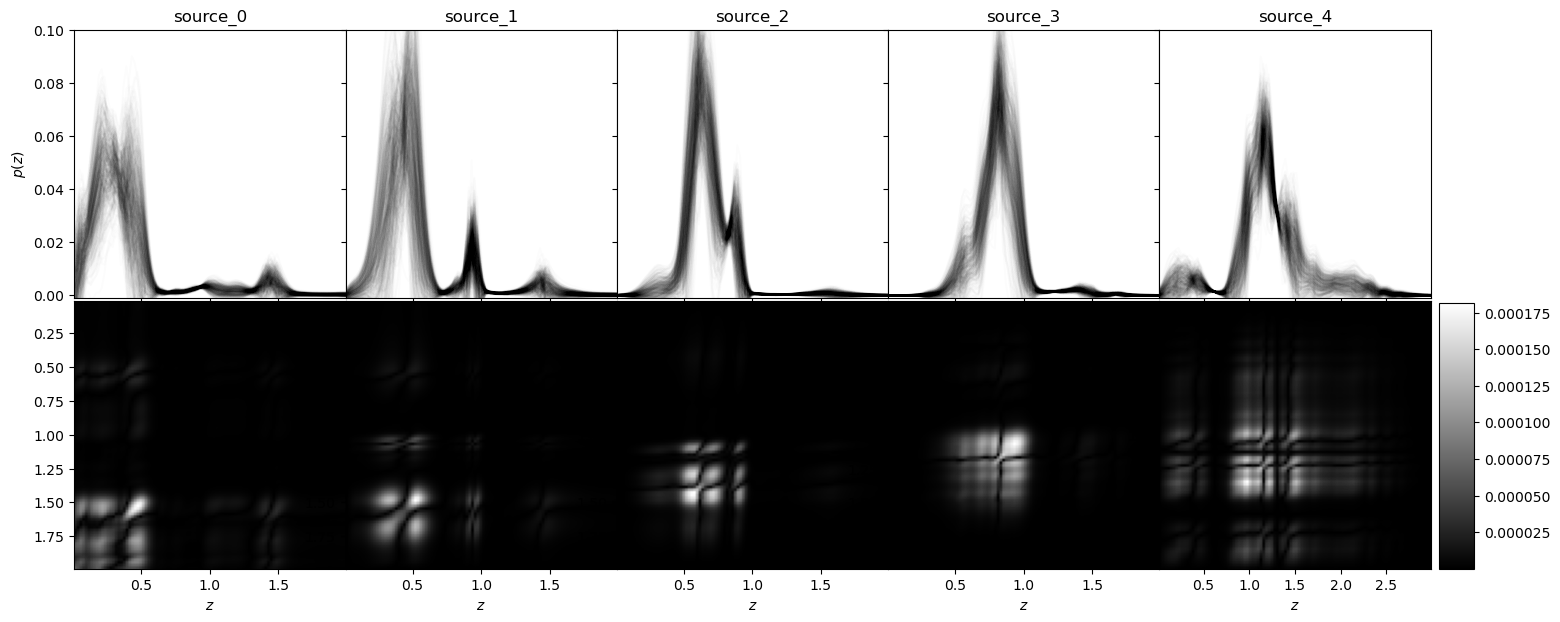

In [40]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(gp_nzs, plot_tracers)

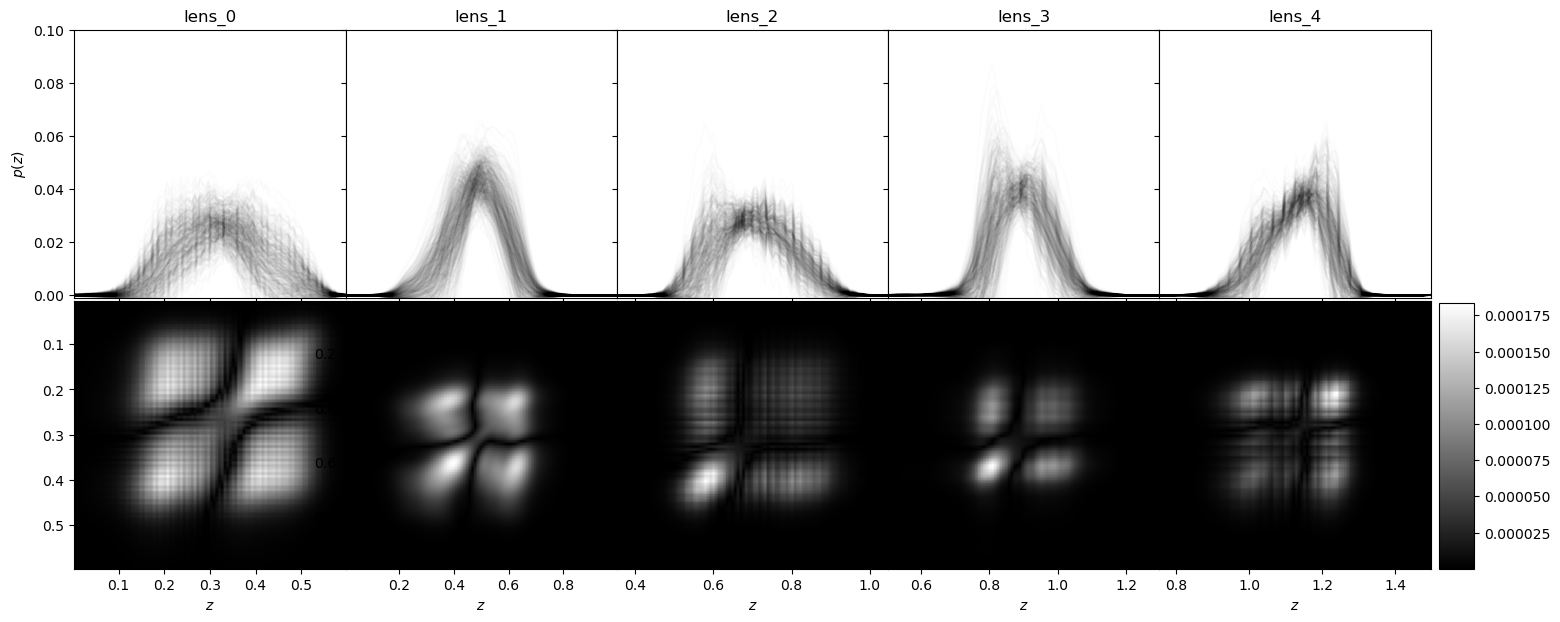

In [41]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(gp_nzs, plot_tracers)

In [42]:
model_objs = gp_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    W = model_obj.W
    W = W @ chol
    file_name = f"gp_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_gp_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, dndz=mean, W=W)


In [ ]:
gp_3_var_comp = {}
gp_var_comp = {}
gp_10_var_comp = {}
gp_20_var_comp = {}
_gp_var_comp = {}
gp_skew_comp = {}
_gp_skew_comp = {}
gp_kurt_comp = {}
_gp_kurt_comp = {}
for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = gp_priors.model_objs[tracer_name]
        shifted_nzs_i = gp_nzs[tracer_name][1].T
        _shifted_nzs_i = _gp_nzs[tracer_name][1].T
        nzs = model_obj.nzs
        zs = model_obj.z
        cov = np.cov(shifted_nzs_i)
        _cov = np.cov(_shifted_nzs_i)
        __cov = model_obj.nz_cov
        errs = np.sqrt(np.diag(cov))
        _errs = np.sqrt(np.diag(_cov))
        __errs = np.sqrt(np.diag(__cov))
        sk = scipy.stats.skew(shifted_nzs_i, axis=1)
        _sk = scipy.stats.skew(_shifted_nzs_i, axis=1)
        __sk = scipy.stats.skew(nzs, axis=0)
        ku = scipy.stats.kurtosis(shifted_nzs_i, axis=1)
        _ku = scipy.stats.kurtosis(_shifted_nzs_i, axis=1)
        __ku = scipy.stats.kurtosis(nzs)
        print(tracer_name, np.mean(errs), np.mean(_errs), np.mean(__errs))
        print(tracer_name, np.mean(sk), np.mean(_sk), np.mean(__sk))
        print(tracer_name, np.mean(ku), np.mean(_ku), np.mean(__ku))
        print("=====")
        gp_var_comp[tracer_name]   = [zs, (errs-__errs)/__errs]
        _gp_var_comp[tracer_name]  = [zs, (_errs-__errs)/__errs]
        gp_skew_comp[tracer_name]  = [zs, (sk-__sk)/__sk]
        _gp_skew_comp[tracer_name] = [zs, (_sk-__sk)/__sk]
        gp_kurt_comp[tracer_name]  = [zs, (ku-__ku)/__ku]
        _gp_kurt_comp[tracer_name] = [zs, (_ku-__ku)/__ku]

source_0 0.004112441732060866 0.0041117149339829516 0.004203544467801479
source_0 0.027478158694411964 0.026285820137557786 1.089871935162711
source_0 -0.09872655689292328 -0.1007415209472398 2.976247856472152
=====
source_1 0.005688894923179402 0.005686945129849328 0.005915508482667201
source_1 -0.019786907134068187 -0.019862614577738563 1.951176083612043
source_1 -0.10648901844617949 -0.10544810554330299 11.418885104639767
=====
source_2 0.0036998492888993323 0.0036980783431321894 0.0038540940899966436
source_2 -0.051408853075501595 -0.05179592620440251 3.1801783128477465
source_2 -0.03731564435910737 -0.03520659000952135 52.538439103022085
=====
source_3 0.003716745519858156 0.003715905838220134 0.003826968983939829
source_3 0.0007914786627305373 0.0012960407412989886 4.181483337161585
source_3 -0.11881809335471027 -0.11761533639953649 67.10002905978006
=====
source_4 0.003851791373921956 0.003850460733469315 0.00394747346337585
source_4 0.04707745561723004 0.04725572437470626 3.283

In [44]:
#gp_Ds = {}
#for tracer_name in gp_nzs.keys():
#    model_obj = gp_priors.model_objs[tracer_name]
#    W = model_obj.W
#    nqs = model_obj.nqs - model_obj.nq_mean
#    _nzs = np.array([np.dot(W, nq) for nq in nqs])
#    _nzs += model_obj.nz_mean 
#    mu_2, K_2 = model_obj.nz_mean, model_obj.nz_cov
#    mu_1, K_1 = np.mean(_nzs, axis=0), np.cov(_nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    gp_Ds[tracer_name] = np.abs(D)

# PCA

In [45]:
PCA_priors_3 = nzp.PriorSacc(ss_qp,
                            model="PCA",
                            compute_crosscorrs=crosscorrs_method,
                            npca=3)

PCA_priors = nzp.PriorSacc(ss_qp,
                            model="PCA",
                            compute_crosscorrs=crosscorrs_method,
                            npca=5)

PCA_priors_10 = nzp.PriorSacc(ss_qp,
                            model="PCA",
                            compute_crosscorrs=crosscorrs_method,
                            npca=10)

PCA_priors_20 = nzp.PriorSacc(ss_qp,
                            model="PCA",
                            compute_crosscorrs=crosscorrs_method,
                            npca=20)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4
Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4
Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4
Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making mod

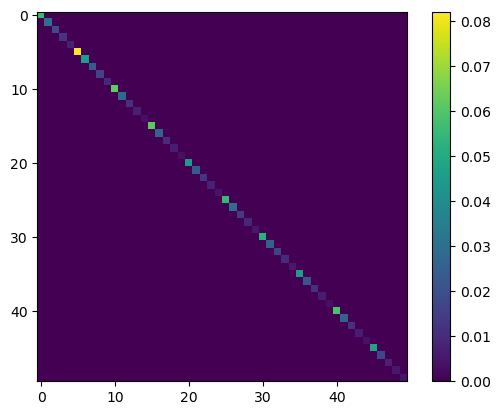

In [46]:
mean, cov, chol = PCA_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(np.sqrt(abs(cov)))
plt.colorbar()

In [47]:
pca_nzs_3 = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = PCA_priors_3.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    eigvecs = model_obj.eigvecs
    z = model_obj.z
    W = (chol.T @ eigvecs).T
    _nzs = np.array([nzp.linear_model(nz_mean, W) for i in range(500)])
    pca_nzs_3[tracer_name] = [z, _nzs]

In [48]:
pca_nzs = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = PCA_priors.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    eigvecs = model_obj.eigvecs
    z = model_obj.z
    W = (chol.T @ eigvecs).T
    _nzs = np.array([nzp.linear_model(nz_mean, W) for i in range(500)])
    pca_nzs[tracer_name] = [z, _nzs]

In [49]:
pca_nzs_10 = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = PCA_priors_10.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    eigvecs = model_obj.eigvecs
    z = model_obj.z
    W = (chol.T @ eigvecs).T
    _nzs = np.array([nzp.linear_model(nz_mean, W) for i in range(500)])
    pca_nzs_10[tracer_name] = [z, _nzs]

In [50]:
pca_nzs_20 = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = PCA_priors_20.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    eigvecs = model_obj.eigvecs
    z = model_obj.z
    W = (chol.T @ eigvecs).T
    _nzs = np.array([nzp.linear_model(nz_mean, W) for i in range(500)])
    pca_nzs_20[tracer_name] = [z, _nzs]

In [51]:
_pca_nzs = {}
for i in range(500):
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = PCA_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = model_obj.params.T[i]
        nz = nzp.pca_model(nz_fid, params, model_obj.eigvecs)[1]
        if i == 0:
            _pca_nzs[tracer_name] = [nz_fid[0], nz]
        else:

            _pca_nzs[tracer_name] = [nz_fid[0], np.vstack([pca_nzs[tracer_name][1], nz])]

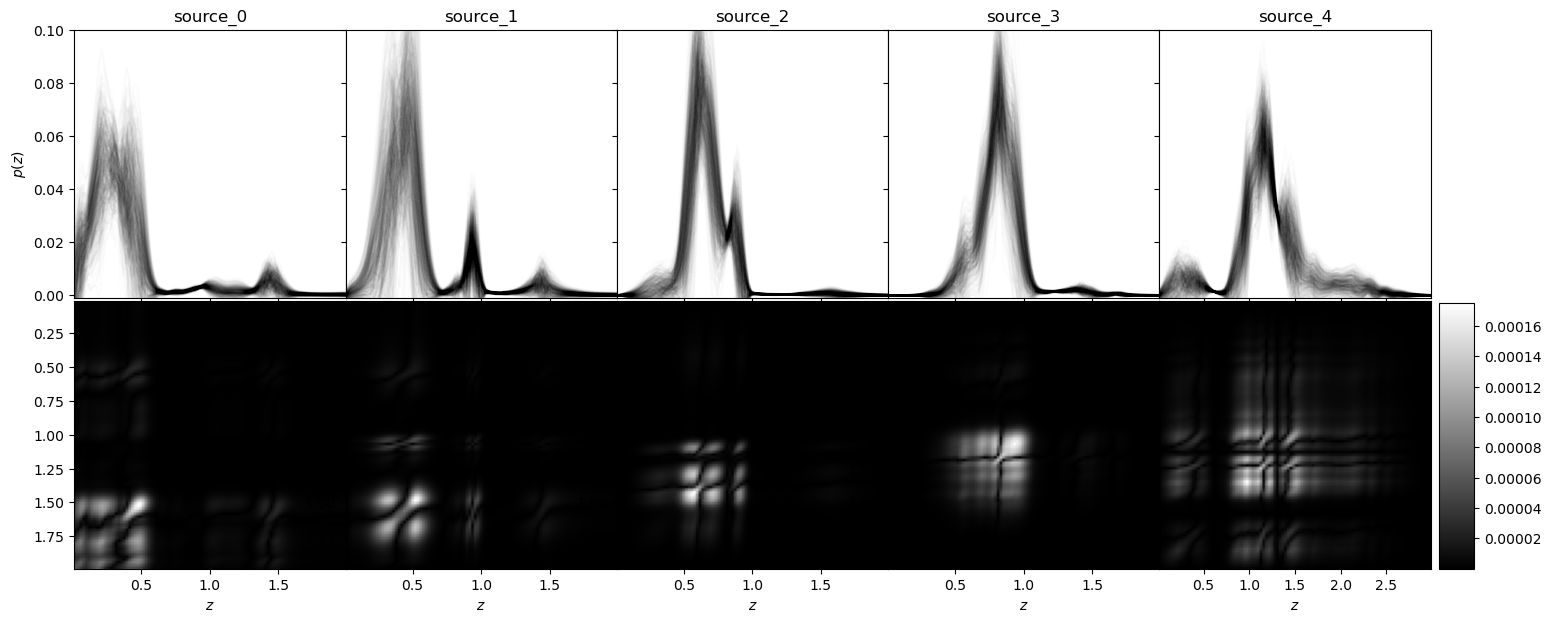

In [52]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(pca_nzs, plot_tracers)

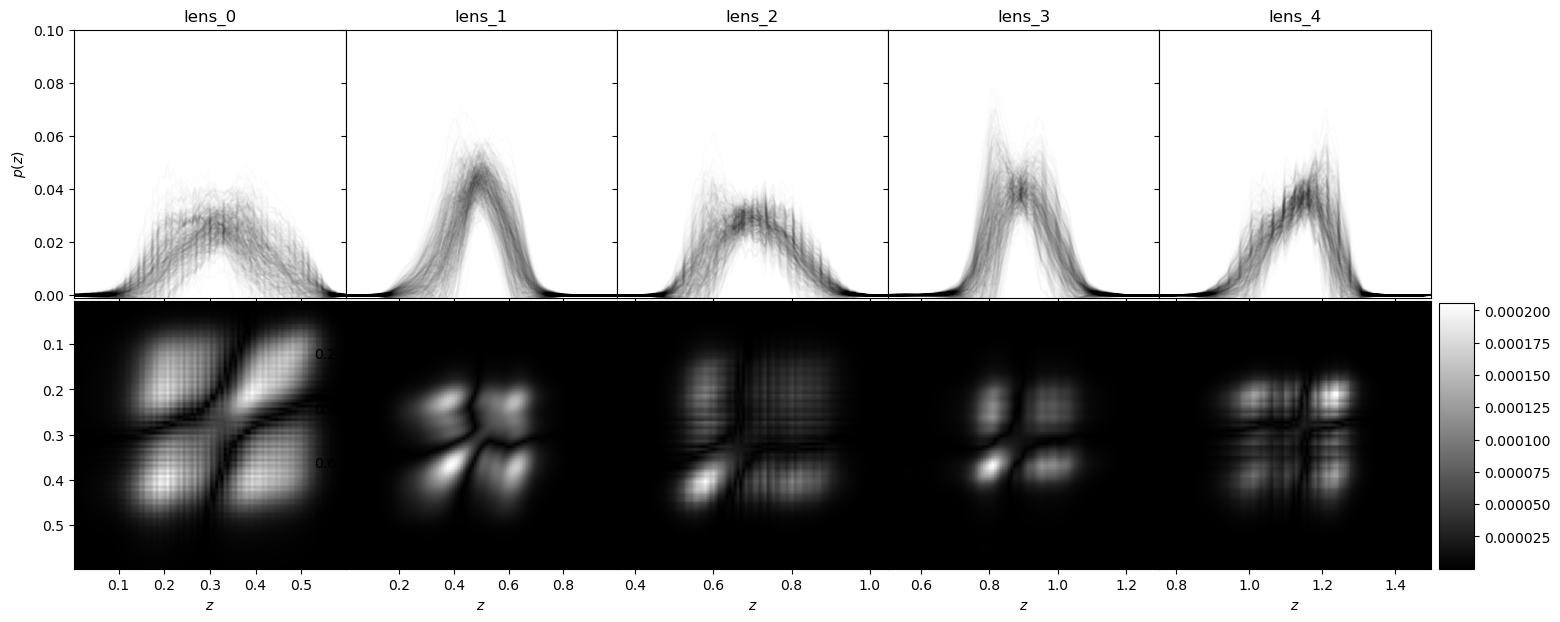

In [53]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(pca_nzs, plot_tracers)

In [54]:
model_objs = PCA_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    eigvecs = model_obj.eigvecs
    _, _, chol = model_obj.get_prior()
    W = (chol.T @ eigvecs).T
    file_name = f"PCA_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_PCA_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, dndz=mean, W=W)

In [55]:
pca_var_comp = {}
_pca_var_comp = {}
pca_skew_comp = {}
_pca_skew_comp = {}
pca_kurt_comp = {}
_pca_kurt_comp = {}
for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = PCA_priors.model_objs[tracer_name]
        shifted_nzs_i = pca_nzs[tracer_name][1].T
        _shifted_nzs_i = _pca_nzs[tracer_name][1].T
        nzs = model_obj.nzs
        zs = model_obj.z
        cov = np.cov(shifted_nzs_i)
        _cov = np.cov(_shifted_nzs_i)
        __cov = model_obj.nz_cov
        errs = np.sqrt(np.diag(cov))
        _errs = np.sqrt(np.diag(_cov))
        __errs = np.sqrt(np.diag(__cov))
        sk = scipy.stats.skew(shifted_nzs_i, axis=1)
        _sk = scipy.stats.skew(_shifted_nzs_i, axis=1)
        __sk = scipy.stats.skew(nzs, axis=0)
        ku = scipy.stats.kurtosis(shifted_nzs_i, axis=1)
        _ku = scipy.stats.kurtosis(_shifted_nzs_i, axis=1)
        __ku = scipy.stats.kurtosis(nzs)
        print(tracer_name, np.mean(errs), np.mean(_errs), np.mean(__errs))
        print(tracer_name, np.mean(sk), np.mean(_sk), np.mean(__sk))
        print(tracer_name, np.mean(ku), np.mean(_ku), np.mean(__ku))
        print("=====")
        pca_var_comp[tracer_name]   = [zs, (errs-__errs)/__errs]
        _pca_var_comp[tracer_name]  = [zs, (_errs-__errs)/__errs]
        pca_skew_comp[tracer_name]  = [zs, (sk-__sk)/__sk]
        _pca_skew_comp[tracer_name] = [zs, (_sk-__sk)/__sk]
        pca_kurt_comp[tracer_name]  = [zs, (ku-__ku)/__ku]
        _pca_kurt_comp[tracer_name] = [zs, (_ku-__ku)/__ku]

source_0 0.0041814224407514524 0.004180646552380714 0.004203544467801479
source_0 0.0031685267266823086 0.0021642656389287943 1.089871935162711
source_0 0.045085688495534904 0.04308977132489687 2.976247856472152
=====
source_1 0.0058937354583446285 0.0058919845037185585 0.005915508482667201
source_1 0.01106954130366863 0.01161935895067159 1.951176083612043
source_1 0.13717556633014502 0.13780545452542295 11.418885104639767
=====
source_2 0.003918302053850713 0.003916766964229979 0.0038540940899966436
source_2 0.0038478857164520024 0.003729519044969573 3.1801783128477465
source_2 -0.1102652706920334 -0.10991276204677612 52.538439103022085
=====
source_3 0.0036278317966213945 0.0036266988021188013 0.003826968983939829
source_3 -0.012292928730535679 -0.011484624257498277 4.181483337161585
source_3 0.06673854865525695 0.06780955654418097 67.10002905978006
=====
source_4 0.003956563460800022 0.003955145122562899 0.00394747346337585
source_4 -0.05644818558773423 -0.05597985151530942 3.283442

In [56]:
#pca_Ds = {}
#for tracer_name in pca_nzs.keys():
#    model_obj = PCA_priors.model_objs[tracer_name]
#    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
#    nzs = pca_nzs[tracer_name][1]
#    mu_2 = np.mean(nzs, axis=0)
#    K_2 = np.cov(nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    pca_Ds[tracer_name] = np.abs(D)

# Comparison

In [57]:
import statistics as stats
def make_var_plots(vars, _vars, tracer_list, labels):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*7,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    colors = ['blue', 'orange', 'green', 'red']
    for i, key in enumerate(tracer_list):
        for j, var in enumerate(vars):
            zs, _var = var[key]
            zs, __var = _vars[j][key]
            m_err = round(stats.mean(np.abs(_var)), 3)
            _m_err = round(stats.mean(np.abs(__var)), 3)
            axis[i].plot(zs, np.abs(_var), color=colors[j], alpha=0.5, label=f"{labels[j]} - Gaussian {m_err}")
            axis[i].plot(zs, np.abs(__var), color=colors[j], alpha=0.5, linestyle='--', label=f"{labels[j]} - True {_m_err}")
        axis[i].plot(zs, np.zeros_like(zs), 'k--')
        axis[i].set_ylim([0.001, 100])
        #axis[i].set_yscale('symlog', linthresh=0.01, linscale=1)
        axis[i].set_yscale('log')
        axis[i].set_title(key)
        axis[i].set_xlabel('z')
        axis[i].legend(ncol=2)
        if i == 0:
            axis[i].set_ylabel('Relative error')
        else:
            axis[i].set_yticklabels([])
    plt.show()
    return figure

def make_var_plots2(vars, tracer_list, labels):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*4,4))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        print(key)
        for j, var in enumerate(vars):
            zs, _var = var[key]
            axis[i].fill_between(zs, np.zeros_like(zs), np.abs(_var), label=labels[j], alpha=0.5)
            print(labels[j], round(np.mean(np.abs(_var)), 3))
        print("====")
        axis[i].plot(zs, np.zeros_like(zs), 'k--')
        axis[i].set_ylim([0.001, 10])
        axis[i].set_yscale('log')
        axis[i].set_title(key)
        axis[i].set_xlabel('z')
        axis[i].legend()
        if i == 0:
            axis[i].set_ylabel('Relative error')
        else:
            axis[i].set_yticklabels([])
    plt.show()
    return figure

In [58]:
labels = ['Shifts', 'Shifts & Widths', 'PCA', 'GP',]

In [59]:
vars = [shifts_var_comp, SnWs_var_comp, pca_var_comp, gp_var_comp]
_vars = [_shifts_var_comp, _SnWs_var_comp, _pca_var_comp, _gp_var_comp]

skews = [shifts_skew_comp, SnWs_skew_comp, pca_skew_comp, gp_skew_comp]
_skews = [_shifts_skew_comp, _SnWs_skew_comp, _pca_skew_comp, _gp_skew_comp]

kurts = [shifts_kurt_comp, SnWs_kurt_comp, pca_kurt_comp, gp_kurt_comp]
_kurts = [_shifts_kurt_comp, _SnWs_kurt_comp, _pca_kurt_comp, _gp_kurt_comp]

In [60]:
source_traces = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
lens_traces = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
shifts_mean_var_comp = np.zeros(2)
SnWs_mean_var_comp = np.zeros(2)
pca_mean_var_comp = np.zeros(2)
gp_mean_var_comp = np.zeros(2)
_shifts_mean_var_comp = np.zeros(2)
_SnWs_mean_var_comp = np.zeros(2)
_pca_mean_var_comp = np.zeros(2)
_gp_mean_var_comp = np.zeros(2)
for tracer_name in source_traces:
    shifts_mean_var_comp[0] += np.mean(shifts_var_comp[tracer_name][1])
    SnWs_mean_var_comp[0] += np.mean(SnWs_var_comp[tracer_name][1])
    pca_mean_var_comp[0] += np.mean(pca_var_comp[tracer_name][1])
    gp_mean_var_comp[0] += np.mean(gp_var_comp[tracer_name][1])
    _shifts_mean_var_comp[0] +=  np.mean(_shifts_var_comp[tracer_name][1])
    _SnWs_mean_var_comp[0] += np.mean(_SnWs_var_comp[tracer_name][1])
    _pca_mean_var_comp[0] += np.mean(_pca_var_comp[tracer_name][1])
    _gp_mean_var_comp[0] += np.mean(_gp_var_comp[tracer_name][1])
for tracer_name in lens_traces:
    shifts_mean_var_comp[1] += np.mean(shifts_var_comp[tracer_name][1])
    SnWs_mean_var_comp[1] += np.mean(SnWs_var_comp[tracer_name][1])
    pca_mean_var_comp[1] += np.mean(pca_var_comp[tracer_name][1])
    gp_mean_var_comp[1] += np.mean(gp_var_comp[tracer_name][1])
    _shifts_mean_var_comp[1] +=  np.mean(_shifts_var_comp[tracer_name][1])
    _SnWs_mean_var_comp[1] += np.mean(_SnWs_var_comp[tracer_name][1])
    _pca_mean_var_comp[1] += np.mean(_pca_var_comp[tracer_name][1])
    _gp_mean_var_comp[1] += np.mean(_gp_var_comp[tracer_name][1])

shifts_mean_var_comp /= len(source_traces)
SnWs_mean_var_comp /= len(source_traces)
pca_mean_var_comp /= len(source_traces)
gp_mean_var_comp /= len(source_traces)
_shifts_mean_var_comp /= len(source_traces)
_SnWs_mean_var_comp /= len(source_traces)
_pca_mean_var_comp /= len(source_traces)
_gp_mean_var_comp /= len(source_traces)


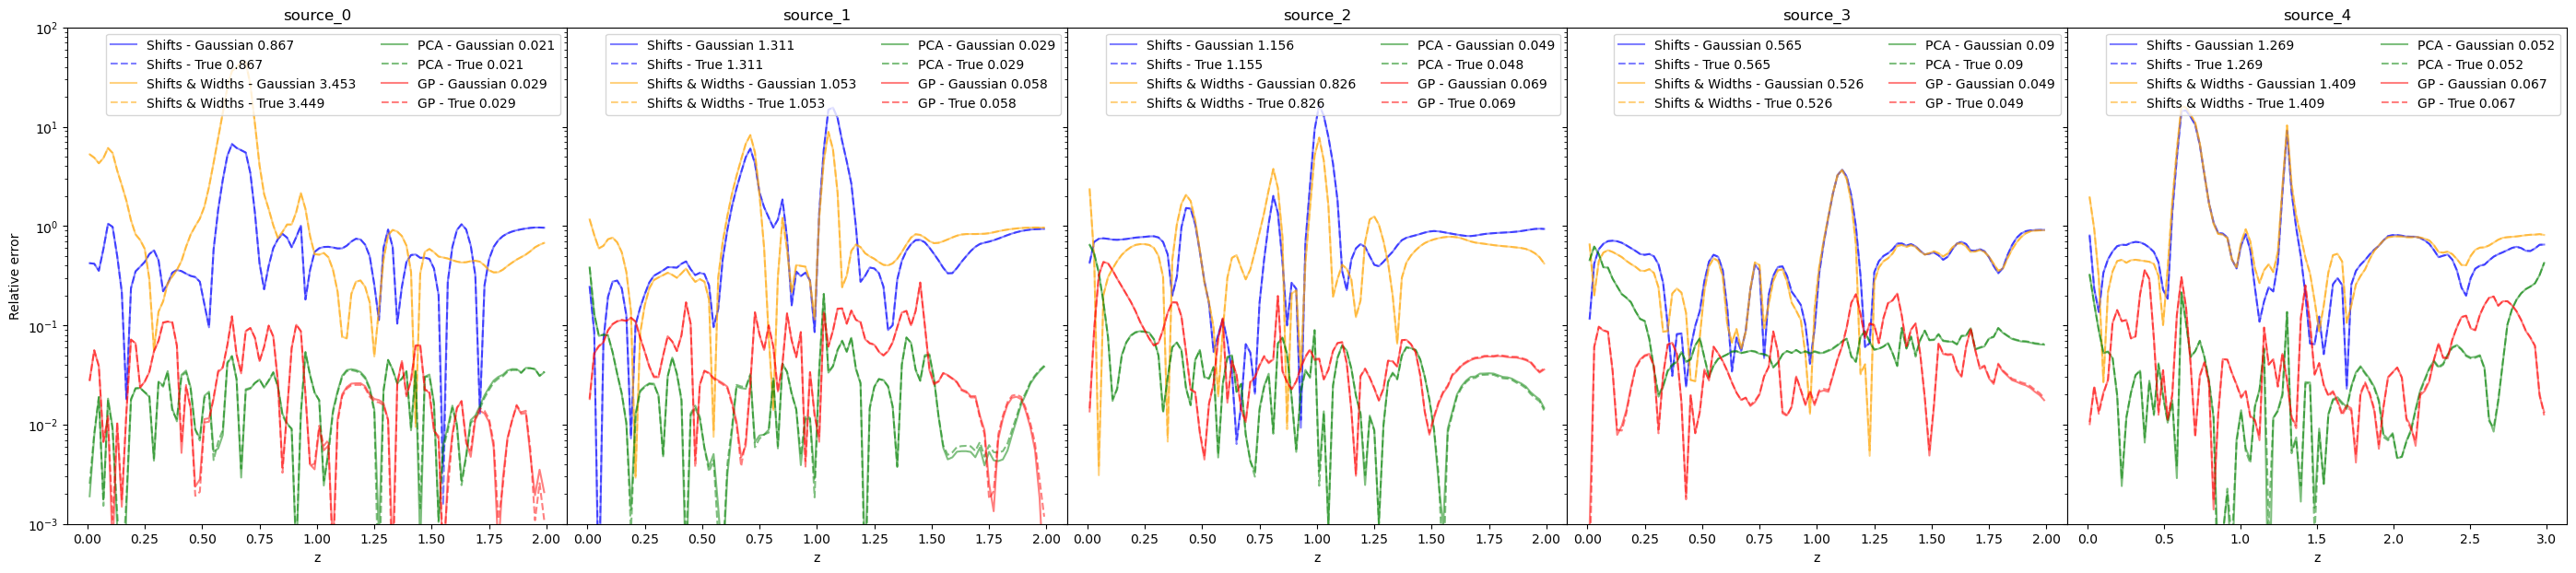

In [61]:
g = make_var_plots(vars, _vars, ['source_0', 'source_1', 'source_2', 'source_3', 'source_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/source_validation.pdf", bbox_inches='tight')

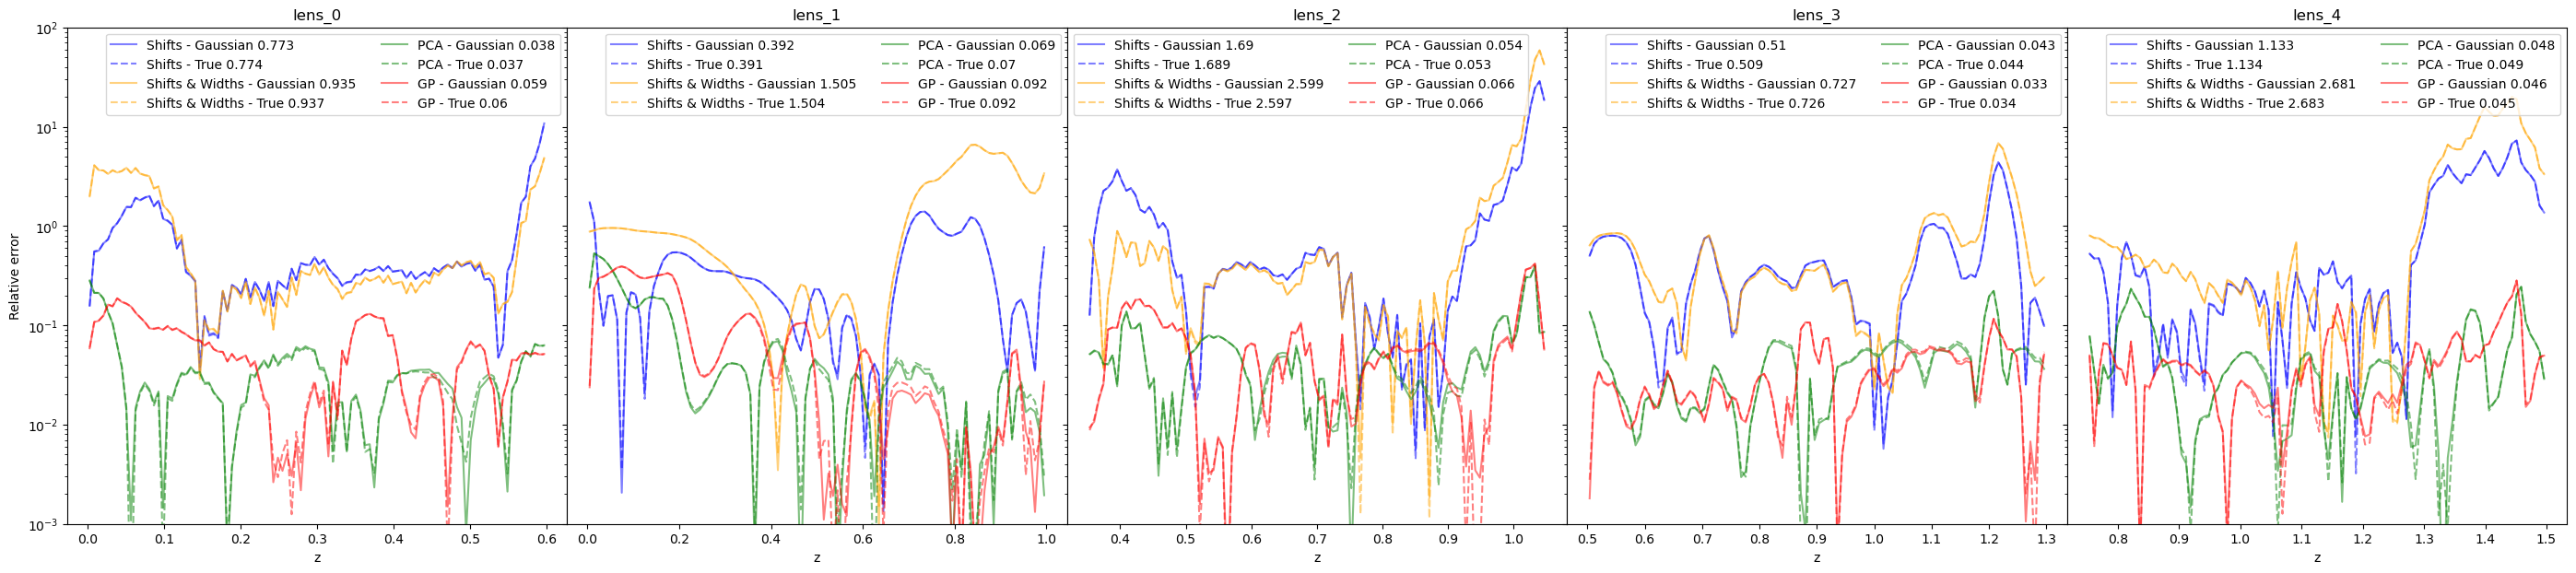

In [62]:
make_var_plots(vars, _vars, ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/lens_validation.pdf", bbox_inches='tight')

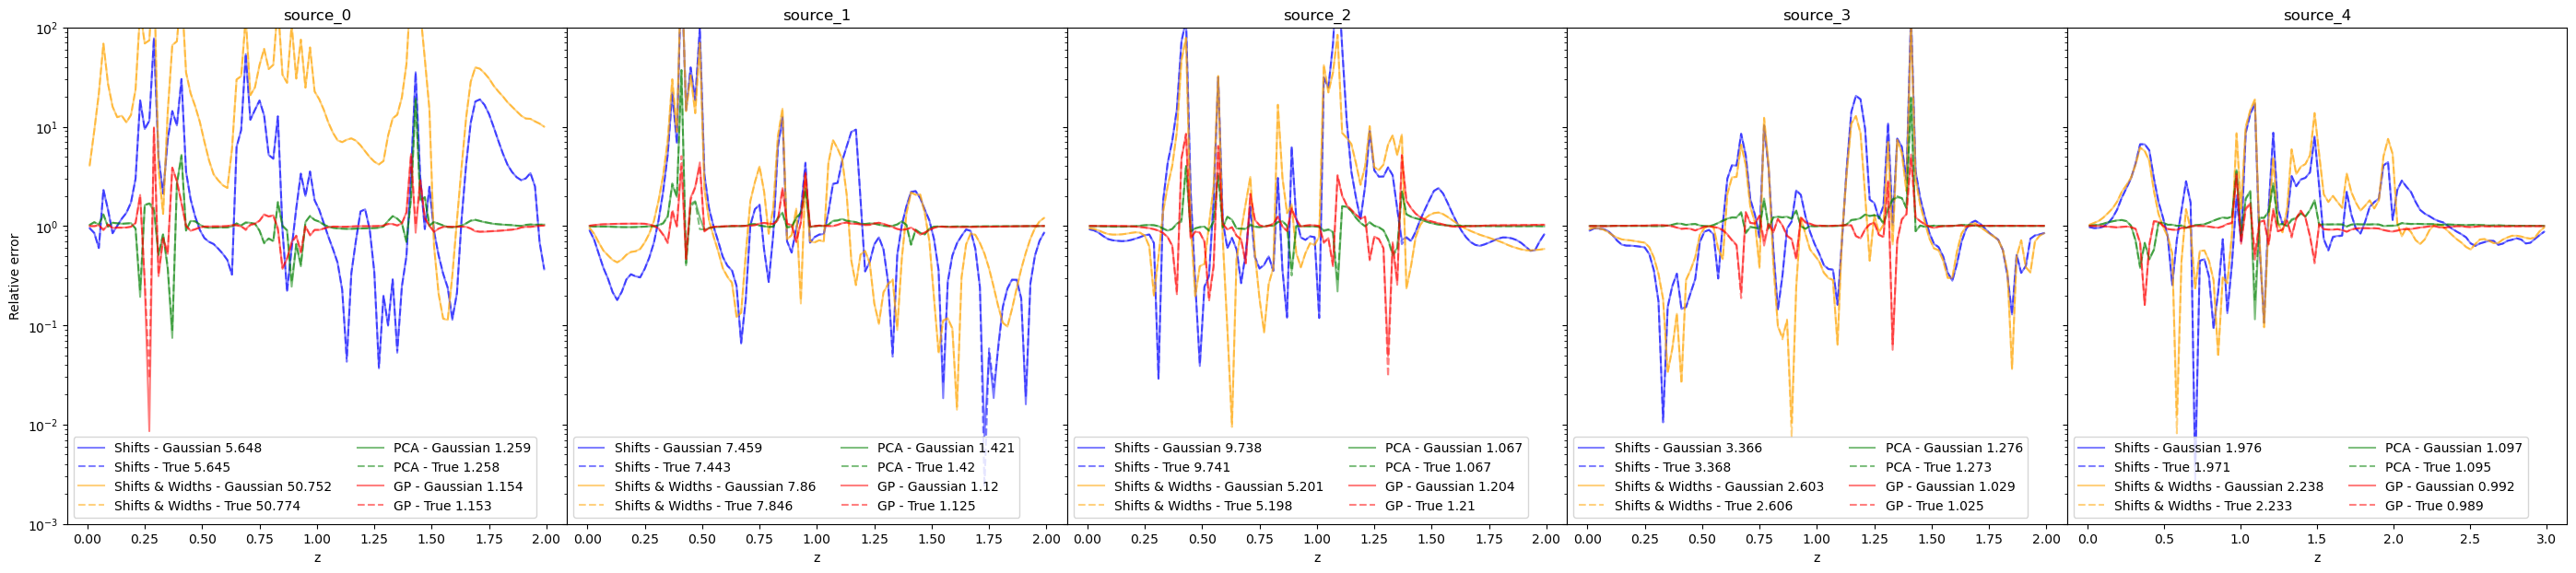

In [63]:
g = make_var_plots(skews, _skews, ['source_0', 'source_1', 'source_2', 'source_3', 'source_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/source_validation.pdf", bbox_inches='tight')

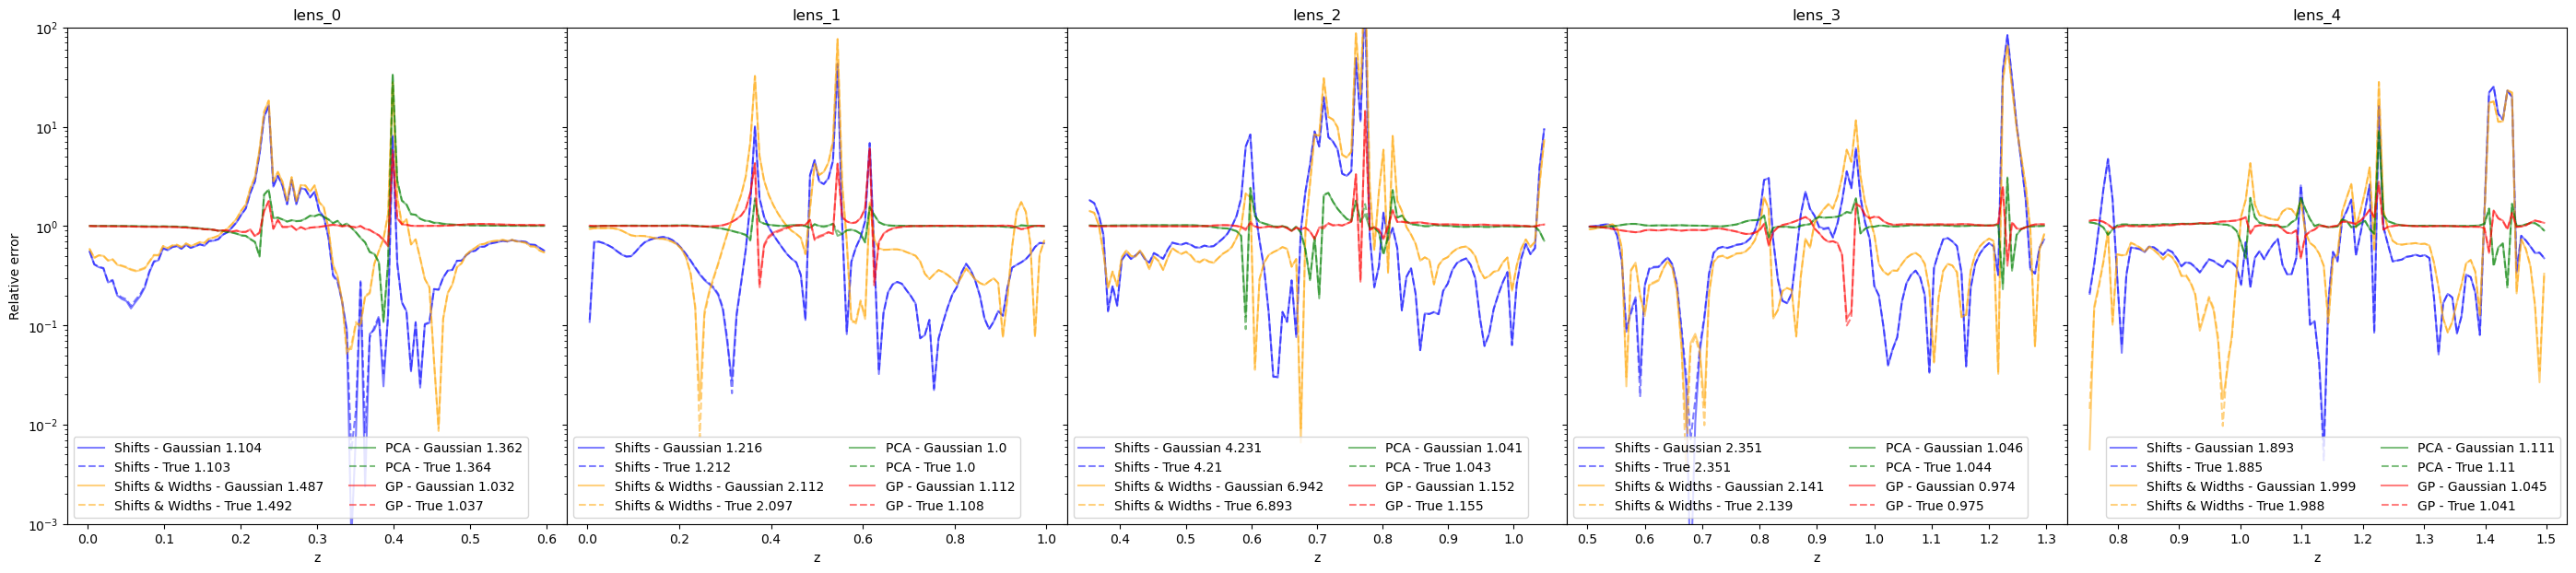

In [64]:
make_var_plots(skews, _skews, ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/lens_validation.pdf", bbox_inches='tight')

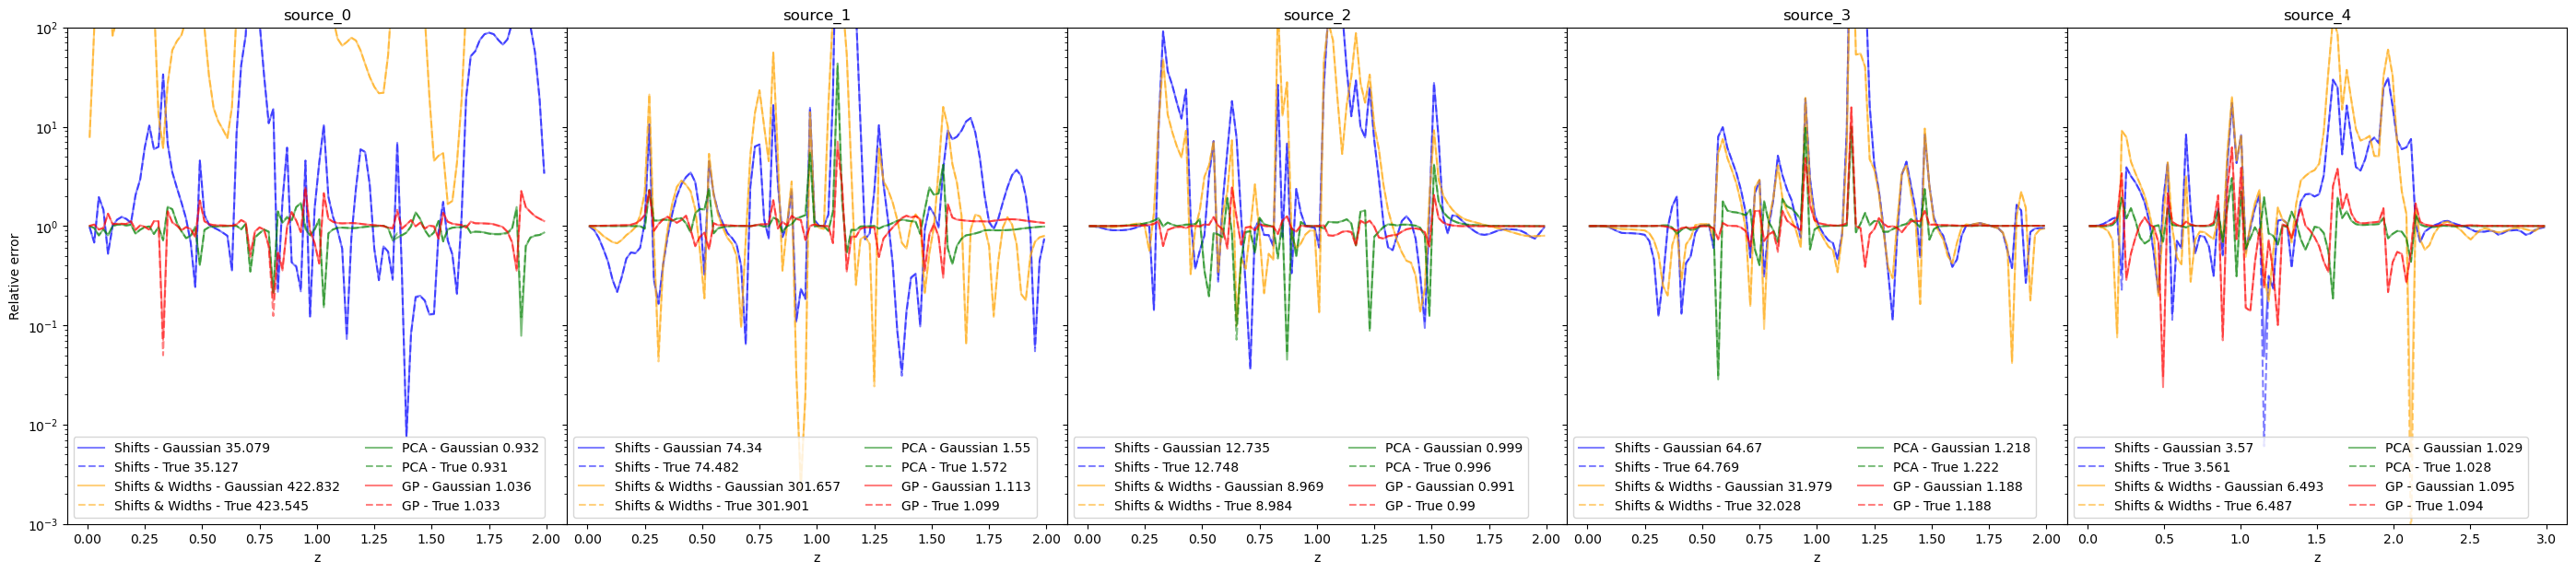

In [65]:
g = make_var_plots(kurts, _kurts, ['source_0', 'source_1', 'source_2', 'source_3', 'source_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/source_validation.pdf", bbox_inches='tight')

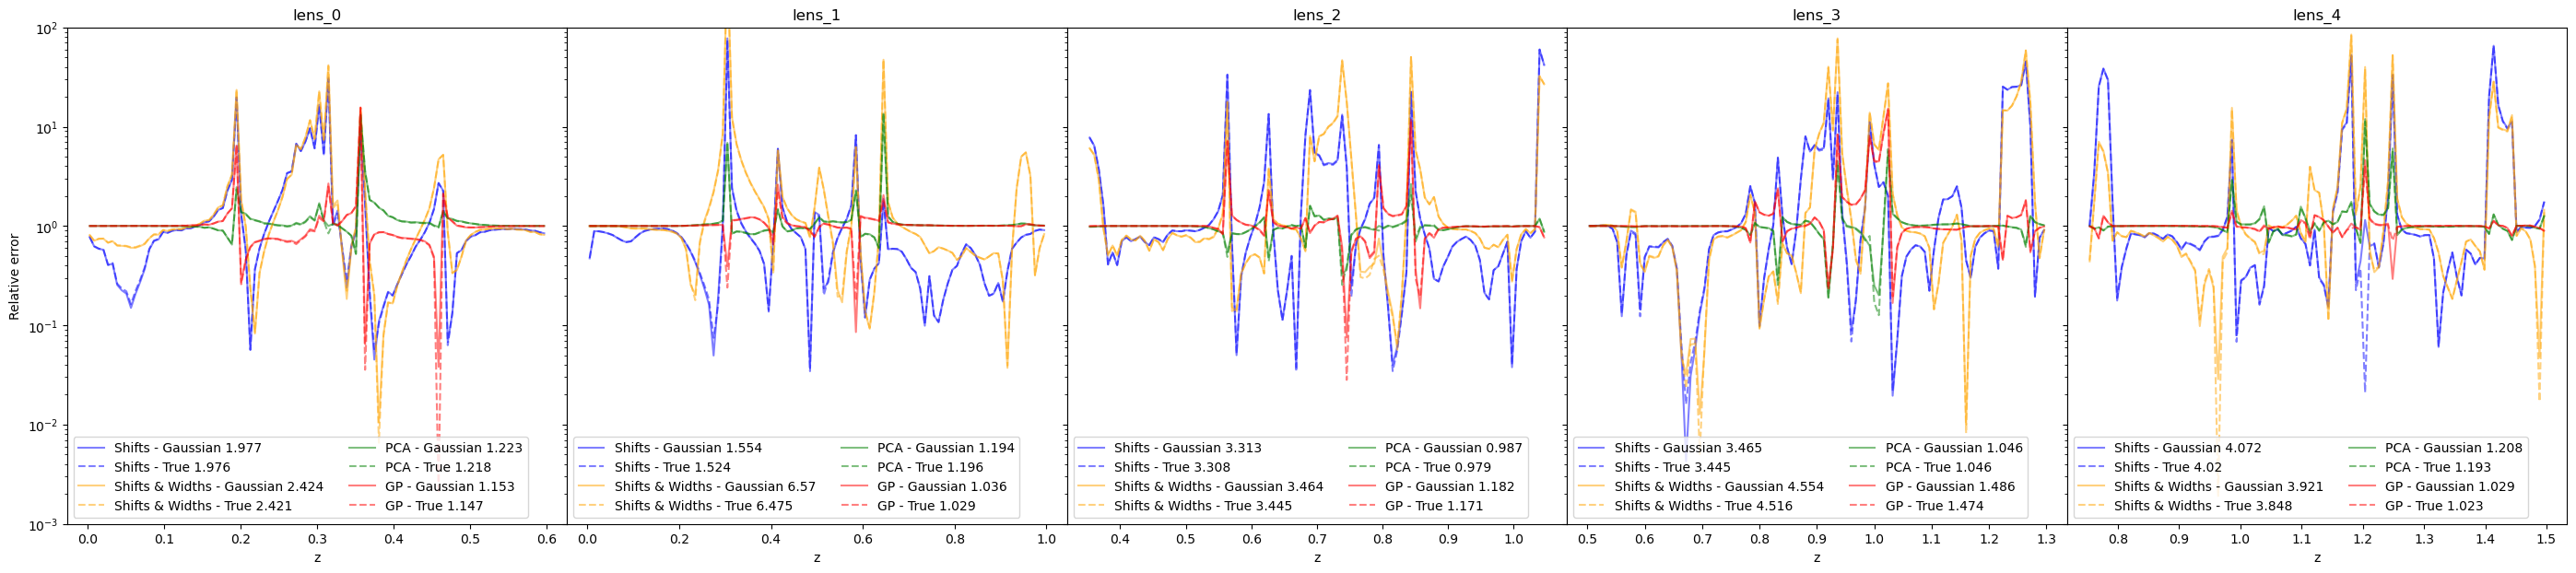

In [66]:
make_var_plots(kurts, _kurts, ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/lens_validation.pdf", bbox_inches='tight')

In [67]:
def make_nzs_comp_plot(methods, tracer):
    n_tracers = len(methods)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(methods):
        method = methods[key]
        tomo = method[tracer]
        if len(tomo) == 2:
            nzs = tomo[1][:50].T
            zs = tomo[0]
        else:
            nzs = tomo['photo_hists'].T[:50].T
            zs = tomo['znodes']
        norms = np.sum(nzs, axis=0)
        axis[0,i].plot(zs, nzs/norms, 'k-', alpha=0.1)
        cov = np.cov(nzs)
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_ylim([-0.001, 0.1])
        axis[0,i].set_title(key, y=0.9)
        if i == 0:
            axis[0,i].set_ylabel(r'$n_{\rm source \, 0}(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()
    return figure

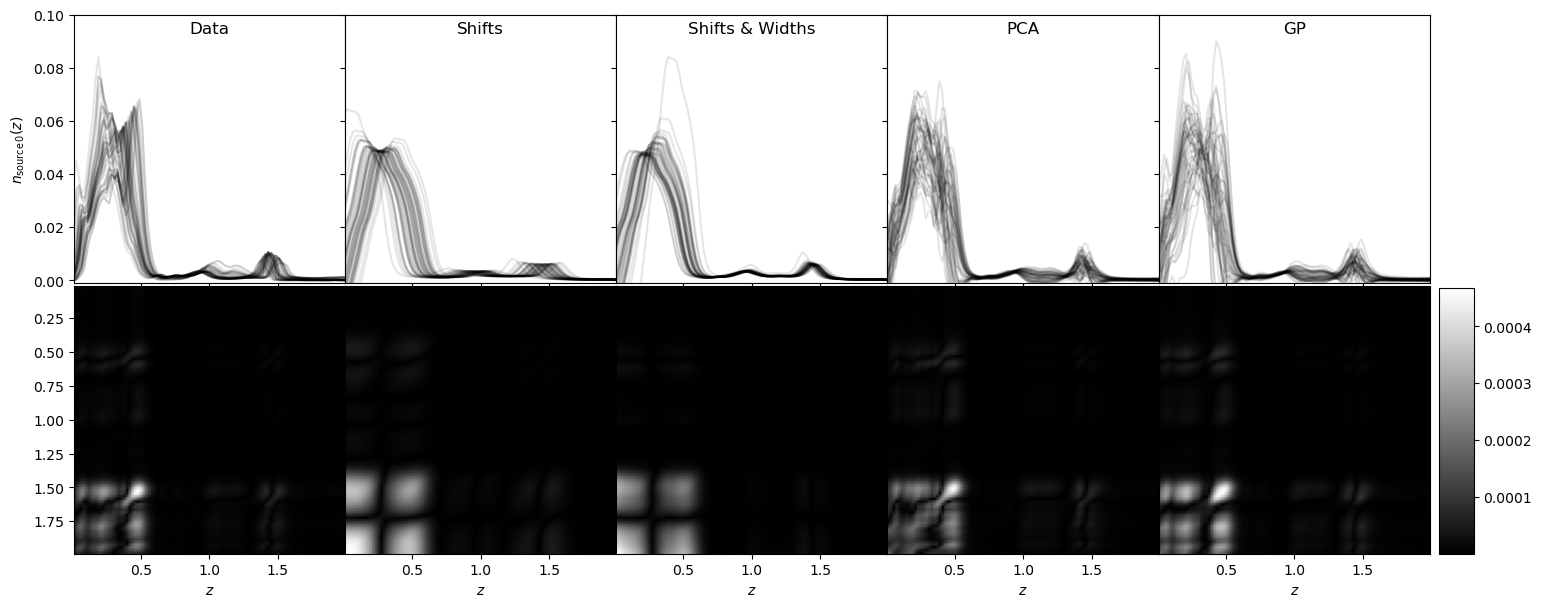

In [68]:
g = make_nzs_comp_plot({'Data': tomos, 'Shifts':shifted_nzs, 'Shifts & Widths':SnWs_nzs, 'PCA':pca_nzs, 'GP':gp_nzs}, 'source_0')
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/source_0_validation.pdf", bbox_inches='tight')

/tmp/ipykernel_29079/1435130265.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  axis[0].plot([2], SnWs_mean_var_comp[1], 'ro-', color="C1", label="Shifts & Widths")


ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

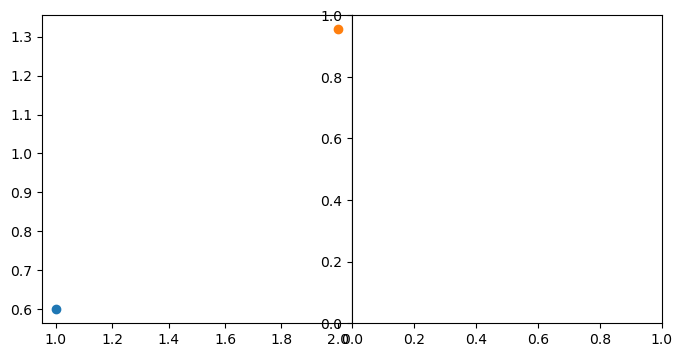

In [69]:
figure, axis = plt.subplots(1, 2, figsize=(2*4,4))
figure.subplots_adjust(wspace=0, hspace=0.01)

axis[0].plot([1], shifts_mean_var_comp[1], 'o-', color="C0", label="Shifts")
axis[0].plot([2], SnWs_mean_var_comp[1], 'ro-', color="C1", label="Shifts & Widths")
axis[0].plot([3,4,5,6], pca_mean_var_comp[1], 'go-', label="PCA")
axis[0].plot([3,4,5,6], gp_mean_var_comp[1], 'ro-', label="GP")
axis[0].set_xticks(np.arange(1, 6+1))
axis[0].set_xticklabels(['1', '2', '3', '5', '10', '20'])
axis[0].set_xlabel('n')
axis[0].set_ylabel('Mean relative error')
axis[0].set_title('Lens')
axis[0].legend()
axis[0].set_yscale('log')
axis[0].set_ylim([0.0, 5])
axis[0].grid(True)

axis[1].plot([1], shifts_mean_var_comp[0], 'o-', color="C0", label="Shifts")
axis[1].plot([2], SnWs_mean_var_comp[0], 'ro-', color="C1", label="Shifts & Widths")
axis[1].plot([3,4,5,6], pca_mean_var_comp[0], 'go-', label="PCA")
axis[1].plot([3,4,5,6], gp_mean_var_comp[0], 'ro-', label="GP")
axis[1].set_xticks(np.arange(1, 6+1))
axis[1].set_xticklabels(['1', '2', '3', '5', '10', '20'])
axis[1].set_xlabel('n')
axis[1].set_title('Sources')
#axis[1].legend()
axis[1].set_yscale('log')
axis[1].set_ylim([0.0, 5])
axis[1].grid(True)
plt.show()